In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

### Load Ticker Pair list

In [3]:
import glob

tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
tickers_list
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values

unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

### Config Data From Files

In [4]:
ticker = 'AAPL'

price_history = pd.read_csv(price_history_dir + f'{ticker}.csv')
sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv')
ti = pd.read_csv(ti_dir + f'{ticker}.csv')

data = {}


class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)
    

In [5]:
display(DATA.AAPL.history.head(2))
display(DATA.AAPL.sentiment.head(2))
display(DATA.AAPL.ti.head(2))


High     Low    Open       Volume  Adj Close
Date                                                        
2021-01-04  133.6116  126.76  133.52  143301887.0     129.41
2021-01-05  131.7400  128.43  128.89   97664898.0     131.01

news_pos_sentiment_count  news_sentiment_daily_avg  \
Date                                                             
2021-01-01                      11.0                    0.0109   
2021-01-04                       3.0                   -0.0008   

            twitter_pos_sentiment_count  
Date                                     
2021-01-01                           15  
2021-01-04                            6

High     Low    Open       Volume  Adj Close           P  \
Date                                                                       
2021-01-04  133.6116  126.76  133.52  143301887.0     129.41  129.927200   
2021-01-05  131.7400  128.43  128.89   97664898.0     131.01  130.393333   

                    R1          R2          R3          S1  ...  momentum_ppo  \
Date                                                        ...                 
2021-01-04  132.544511  134.161489  136.778800  127.309889  ...      0.000000   
2021-01-05  131.657753  132.438913  133.703333  129.128913  ...      0.098538   

            momentum_ppo_signal  momentum_ppo_hist  momentum_pvo  \
Date                                                               
2021-01-04             0.000000           0.000000       0.00000   
2021-01-05             0.019708           0.078831      -2.60186   

            momentum_pvo_signal  momentum_pvo_hist  momentum_kama  others_dr  \
Date                                                                           
2021-01-04             0.000000           0.000000     129.410000    0.00000   
2021-01-05            -0.520372          -2.081488     130.210469    1.23638   

            others_dlr  others_cr  
Date                               
2021-01-04      0.0000    0.00000  
2021-01-05      1.2288    1.23638  

[2 rows x 122 columns]

In [6]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df


### Load and Merge Data for Pair
change PAIR_IDX to the pair you want to analyze

In [7]:
PAIR_IDX = 0

pair = pairs[PAIR_IDX]

print(pair)

ADD_SENTIMENT_MA = True

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge(
    data[pair[0]].sentiment,
    data[pair[1]].sentiment,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(
        pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns
    )

# Join Technical Indicators
pair_ti_df = pd.merge(
    data[pair[0]].ti,
    data[pair[1]].ti,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)

pair_df = pd.merge(
    pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left"
)

print(pair_df.shape, pair_df.shape[0] * pair_df.shape[1])
pair_df

['GS' 'BLK']
(815, 268) 218420


/var/folders/l3/3msj1f8x6v930zvr96b6w9bh0000gn/T/ipykernel_77357/491297819.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


High_S1  Low_S1  Open_S1  Volume_S1  Adj Close_S1        P_S1  \
Date                                                                         
2021-01-04  267.5800  260.16   267.00  3572043.0        265.00  264.246667   
2021-01-05  273.5000  262.57   263.88  4207081.0        270.93  269.000000   
2021-01-06  288.3800  273.10   276.29  6383530.0        285.55  282.343333   
2021-01-07  295.8894  286.68   287.77  4009730.0        291.65  291.406467   
2021-01-08  292.2800  285.06   292.00  2800784.0        290.08  289.140000   
...              ...     ...      ...        ...           ...         ...   
2024-03-25  410.4600  403.86   406.87  1683977.0        404.94  406.420000   
2024-03-26  409.3300  404.52   406.09  1406974.0        406.18  406.676667   
2024-03-27  415.4900  408.37   409.62  2353629.0        415.25  413.036667   
2024-03-28  419.2000  414.98   416.21  2409718.0        417.69  417.290000   
2024-04-01  417.9500  412.00   416.68  1863918.0        413.51  414.486667   

                 R1_S1       R2_S1       R3_S1       S1_S1  ...  \
Date                                                        ...   
2021-01-04  267.081107  268.832227  271.666667  261.412227  ...   
2021-01-05  273.175260  275.754740  279.930000  264.824740  ...   
2021-01-06  288.180293  291.786373  297.623333  276.506373  ...   
2021-01-07  294.924457  297.097876  300.615867  287.888476  ...   
2021-01-08  291.898040  293.601960  296.360000  286.381960  ...   
...                ...         ...         ...         ...  ...   
2024-03-25  408.941200  410.498800  413.020000  403.898800  ...   
2024-03-26  408.514087  409.649247  411.486667  404.839247  ...   
2024-03-27  415.756507  417.436827  420.156667  410.316827  ...   
2024-03-28  418.902040  419.897960  421.510000  415.677960  ...   
2024-04-01  416.759567  418.163767  420.436667  412.213767  ...   

            twitter_pos_sentiment_count_S1_ma10  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                                 13.5   
2024-03-26                                 14.1   
2024-03-27                                 15.6   
2024-03-28                                 16.4   
2024-04-01                                  NaN   

            news_sentiment_daily_avg_S2_ma10  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                          -0.00518   
2024-03-26                          -0.00433   
2024-03-27                          -0.00290   
2024-03-28                          -0.00550   
2024-04-01                               NaN   

            twitter_pos_sentiment_count_S2_ma10  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                                 26.0   
2024-03-26                                 25.3   
2024-03-27                                 22.1   
2024-03-28                                 27.9   
2024-04-01                                  NaN   

            news_pos_sentiment_count_S2_ma10  \
Date                                           
2021-01-04                               NaN   
2021-01-05                   


### calculate spread


<Axes: title={'center': 'Spread'}, xlabel='Date'>

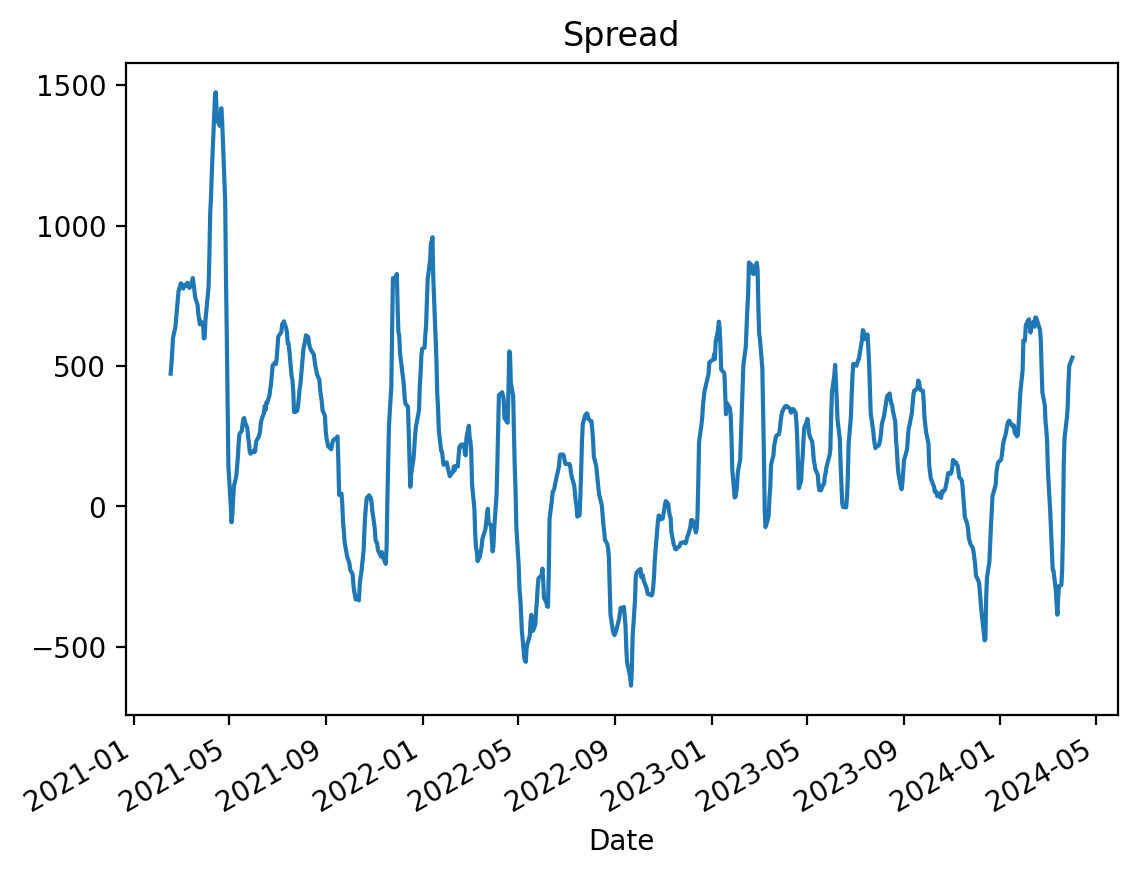

In [8]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df



SPREAD_WINDOW = 30
spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

pair_df['spread'].plot(title='Spread')


### Create Target 

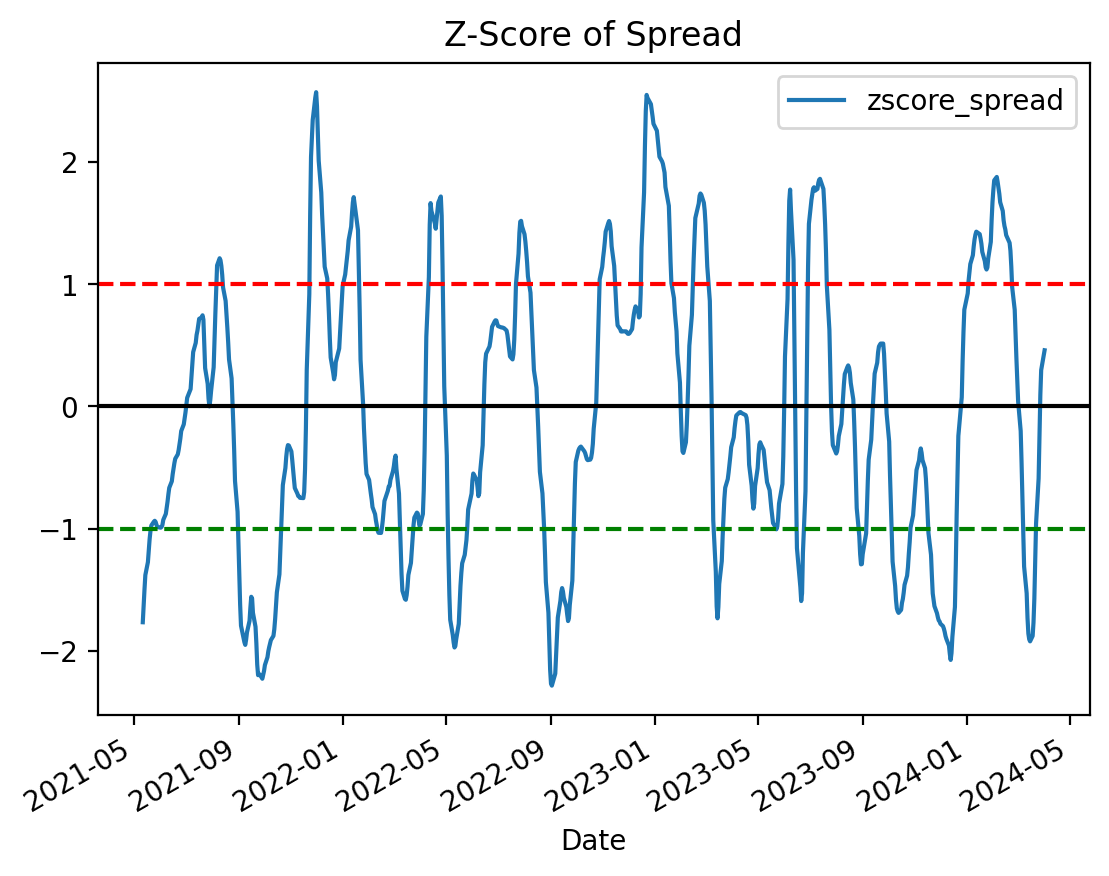

High_S1  Low_S1  Open_S1  Volume_S1  Adj Close_S1        P_S1  \
Date                                                                         
2021-01-04  267.5800  260.16   267.00  3572043.0        265.00  264.246667   
2021-01-05  273.5000  262.57   263.88  4207081.0        270.93  269.000000   
2021-01-06  288.3800  273.10   276.29  6383530.0        285.55  282.343333   
2021-01-07  295.8894  286.68   287.77  4009730.0        291.65  291.406467   
2021-01-08  292.2800  285.06   292.00  2800784.0        290.08  289.140000   
...              ...     ...      ...        ...           ...         ...   
2024-03-25  410.4600  403.86   406.87  1683977.0        404.94  406.420000   
2024-03-26  409.3300  404.52   406.09  1406974.0        406.18  406.676667   
2024-03-27  415.4900  408.37   409.62  2353629.0        415.25  413.036667   
2024-03-28  419.2000  414.98   416.21  2409718.0        417.69  417.290000   
2024-04-01  417.9500  412.00   416.68  1863918.0        413.51  414.486667   

                 R1_S1       R2_S1       R3_S1       S1_S1  ...  \
Date                                                        ...   
2021-01-04  267.081107  268.832227  271.666667  261.412227  ...   
2021-01-05  273.175260  275.754740  279.930000  264.824740  ...   
2021-01-06  288.180293  291.786373  297.623333  276.506373  ...   
2021-01-07  294.924457  297.097876  300.615867  287.888476  ...   
2021-01-08  291.898040  293.601960  296.360000  286.381960  ...   
...                ...         ...         ...         ...  ...   
2024-03-25  408.941200  410.498800  413.020000  403.898800  ...   
2024-03-26  408.514087  409.649247  411.486667  404.839247  ...   
2024-03-27  415.756507  417.436827  420.156667  410.316827  ...   
2024-03-28  418.902040  419.897960  421.510000  415.677960  ...   
2024-04-01  416.759567  418.163767  420.436667  412.213767  ...   

            twitter_pos_sentiment_count_S2_ma10  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                                 26.0   
2024-03-26                                 25.3   
2024-03-27                                 22.1   
2024-03-28                                 27.9   
2024-04-01                                  NaN   

            news_pos_sentiment_count_S2_ma10  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                               0.9   
2024-03-26                               0.9   
2024-03-27                               1.0   
2024-03-28                               1.1   
2024-04-01                               NaN   

            news_pos_sentiment_count_S1_ma20  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                              1.65   
2024-03-26                              1.65   
2024-03-27                              1.55   
2024-03-28                              1.55   
2024-04-01                               NaN   

            news_sentiment_daily_avg_S1_ma20  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06          

In [9]:

# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

# Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=60).mean()
ma_low = pair_df.spread.rolling(window=5).mean()
std_high = pair_df.spread.rolling(window=60).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


pair_df['zscore_spread'].plot(title='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend()
plt.show()
pair_df

In [10]:
plt.style.use('custom_onedark')



In [11]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [12]:
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.7, 0.2, 0.1], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size



    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()], 
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



## Dataset Setup

In [22]:
# Parameters
LOOK_BACK = 3
DROP_COLS = [
   
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     506  2023-05-15
Val       144  2023-08-29
Test       73  2023-12-08


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


R2: -2.31, MAE: 1.54, MAPE: 576.72%


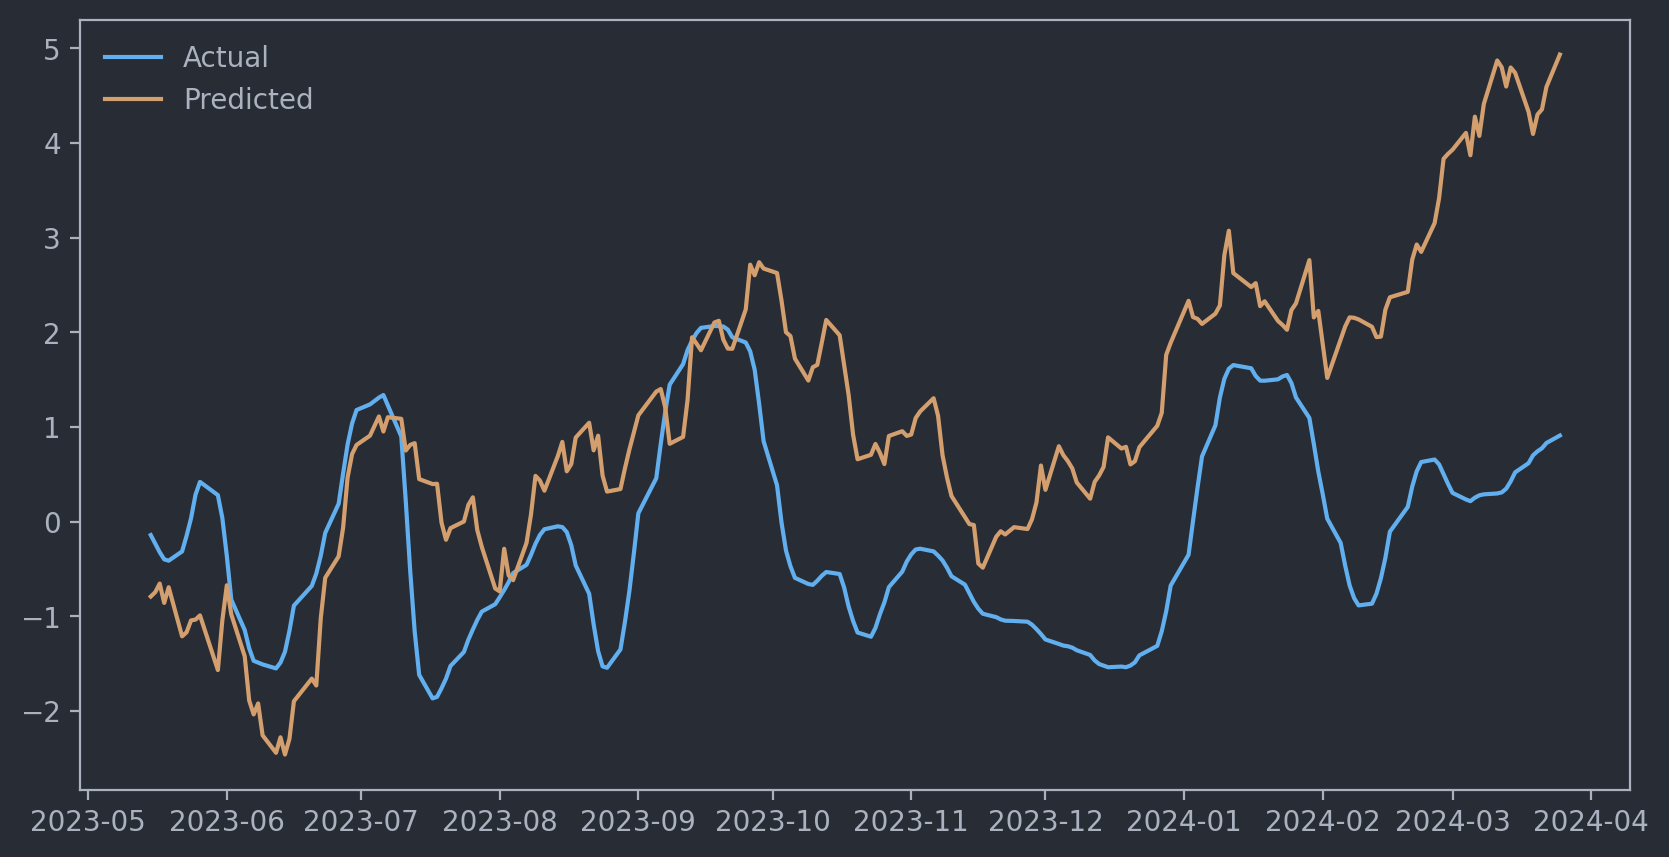

In [24]:
# ---- Model Training ----
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}
model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred)


fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# get feature importance
feature_importance = model_reg.coef_
features = X_train.columns
feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)
model_results['Gradient Boosting Regressor'] = calculate_metrics(
    y_test, y_pred)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nR2: {r2:.2f}, MAE: {mae:.2f}")



R2: 0.59, MAE: 0.51, MAPE: 195.70%

R2: 0.59, MAE: 0.51


In [69]:
print('Original Feature Dim:', feature_importance_df.shape[0])

# Can Change Thresholds, By no means are these the best thresholds
# Should use another method for feature selection, this was just for demonstration
low_importance_df = feature_importance_df[(feature_importance_df['importance'] < 1) & (feature_importance_df['importance'] > -1)]
print('Low Importance Feature Dim:', low_importance_df.shape[0])

low_importance_cols = low_importance_df.feature.to_list()
high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= 1) | (feature_importance_df['importance'] <= -1)]

Original Feature Dim: 252
Low Importance Feature Dim: 241


### Train regression again with low importance columns removed

In [17]:

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=low_importance_cols
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])



model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

NameError: name 'low_importance_cols' is not defined

# General Setup

In [18]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.7, 0.2, 0.1], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size



    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()], 
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



['JPM' 'CRM']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04


/var/folders/l3/3msj1f8x6v930zvr96b6w9bh0000gn/T/ipykernel_77357/3152546308.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



R2: -6.05, MAE: 2.34, MAPE: 866.81%


High_S1    Low_S1  Open_S1   Volume_S1  Adj Close_S1        P_S1  \
Date                                                                            
2021-01-04  127.8579  124.7800   127.50  16819915.0        125.87  126.169300   
2021-01-05  126.2995  123.7700   124.99  13731206.0        125.65  125.239833   
2021-01-06  132.7700  127.8800   129.88  24909056.0        131.55  130.733333   
2021-01-07  138.1900  134.9200   135.69  21940387.0        135.87  136.326667   
2021-01-08  136.3500  134.1200   135.97  12035126.0        136.02  135.496667   
...              ...       ...      ...         ...           ...         ...   
2024-03-25  196.9400  194.3600   196.60   8620015.0        194.82  195.373333   
2024-03-26  196.6600  194.0554   194.59   5961484.0        195.73  195.481800   
2024-03-27  199.6000  196.3800   196.50   8725757.0        199.52  198.500000   
2024-03-28  200.7200  198.5400   199.49   8628313.0        200.30  199.853333   
2024-04-01  200.9400  198.5650   199.99   7309009.0        198.94  199.481667   

                 R1_S1       R2_S1       R3_S1       S1_S1  ...  \
Date                                                        ...   
2021-01-04  127.345058  128.071442  129.247200  124.993542  ...   
2021-01-05  126.206102  126.803064  127.769333  124.273564  ...   
2021-01-06  132.601313  133.755353  135.623333  128.865353  ...   
2021-01-07  137.575807  138.347527  139.596667  135.077527  ...   
2021-01-08  136.348527  136.874807  137.726667  134.644807  ...   
...                ...         ...         ...         ...  ...   
2024-03-25  196.358893  196.967773  197.953333  194.387773  ...   
2024-03-26  196.476757  197.091443  198.086400  194.486843  ...   
2024-03-27  199.730040  200.489960  201.720000  197.269960  ...   
2024-03-28  200.686093  201.200573  202.033333  199.020573  ...   
2024-04-01  200.388917  200.949417  201.856667  198.574417  ...   

            news_sentiment_daily_avg_S2_ma10  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                           0.03766   
2024-03-26                           0.02824   
2024-03-27                           0.00437   
2024-03-28                           0.00579   
2024-04-01                               NaN   

            twitter_pos_sentiment_count_S2_ma10  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                                  0.2   
2024-03-26                                  0.4   
2024-03-27                                  0.4   
2024-03-28                                  0.5   
2024-04-01                                  NaN   

            news_pos_sentiment_count_S1_ma20  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                              2.65   
2024-03-26                              2.85   
2024-03-27                              2.75   
2024-03-28                              2.60   
2024-04-01                               NaN   

            news_sentiment_daily_avg_S1_ma20  \
Date                                           
2021-01-04                               NaN   
2021-01-05                   

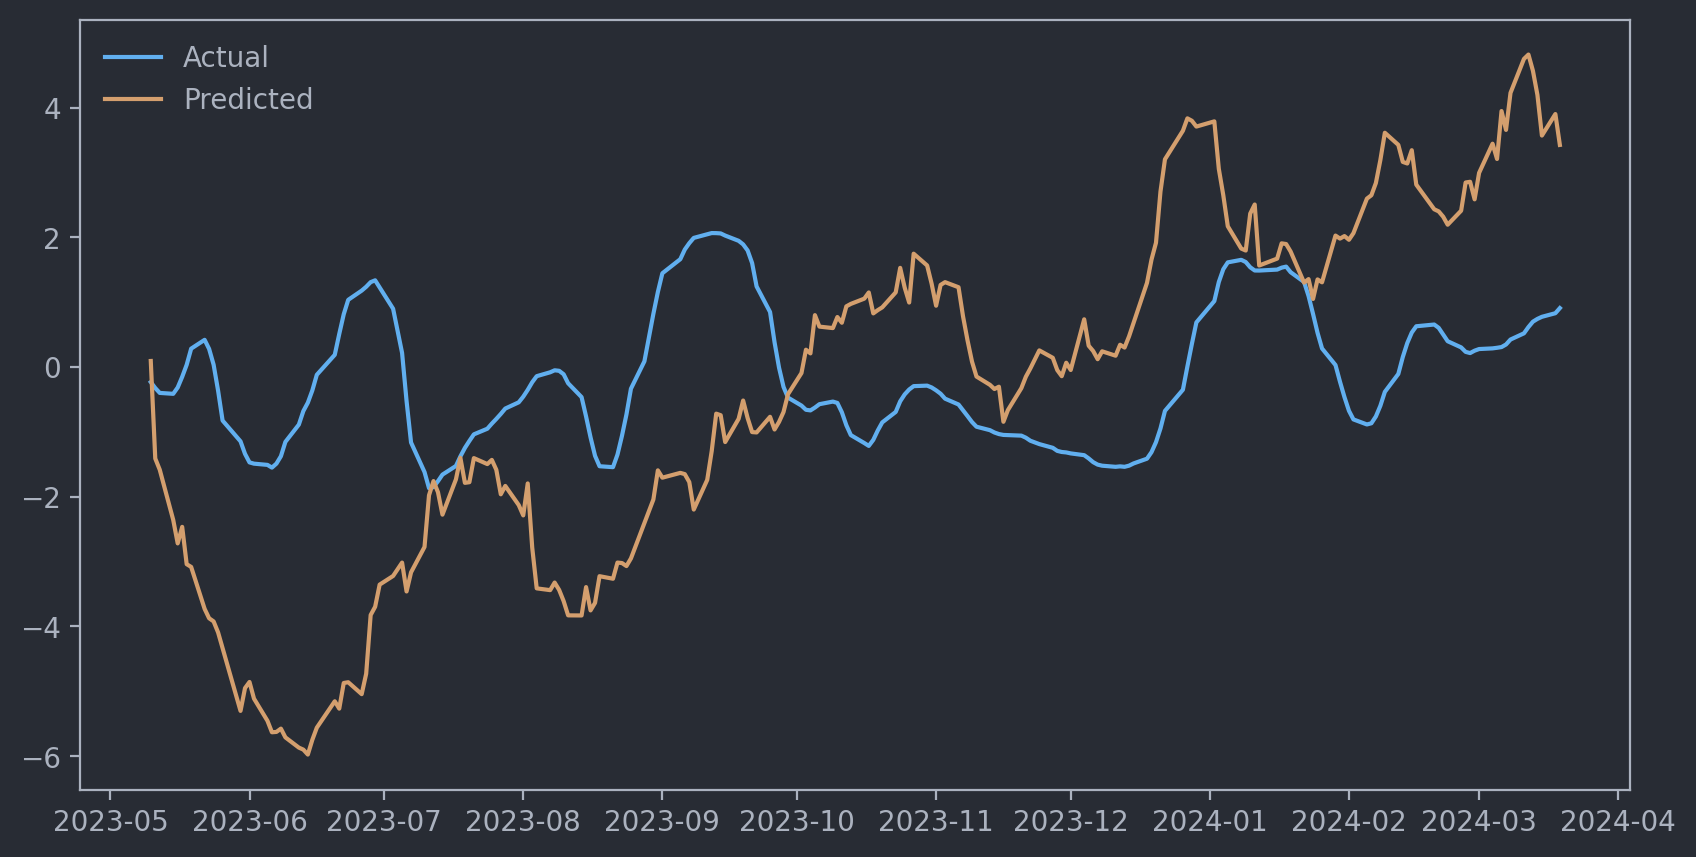

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS



data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

import glob

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')


# Load Ticker History, Sentiment and Technical Indicators
data = {}
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)



# Pair Selection
PAIR_IDX = 1
ADD_SENTIMENT_MA = True


pair = pairs[PAIR_IDX]
print(pair)

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns)

# Join Technical Indicators
pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")



# ---- Dataset Setup ----
# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

SPREAD_WINDOW = 30
MA_HIGH = 60
MA_LOW = 5

# Parameters
LOOK_BACK = 7
DROP_COLS = [

]
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

# Calculate Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
std_high = pair_df.spread.rolling(window=MA_HIGH).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}
model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred)


fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# --- Feature Selection Setup ---


# # get feature importance
# feature_importance = model_reg.coef_
# features = X_train.columns
# feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
# feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# print('Original Feature Dim:', feature_importance_df.shape[0])

# # Can Change Thresholds, By no means are these the best thresholds
# # Should use another method for feature selection, this was just for demonstration
# low_importance_df = feature_importance_df[(feature_importance_df['importance'] < 1) & (feature_importance_df['importance'] > -1)]
# print('Low Importance Feature Dim:', low_importance_df.shape[0])

# low_importance_cols = low_importance_df.feature.to_list()
# high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= 1) | (feature_importance_df['importance'] <= -1)]

# train_data, val_data, test_data = create_dataset(
#     pair_df, 
#     look_back=LOOK_BACK, 
#     target_col="zscore_spread", 
#     drop_cols=low_importance_cols
# )

# X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# print("LOOK_BACK:", LOOK_BACK)
# print(X_train.shape, y_train.shape)

pair_df


R2: -6.05, MAE: 2.34, MAPE: 866.81%


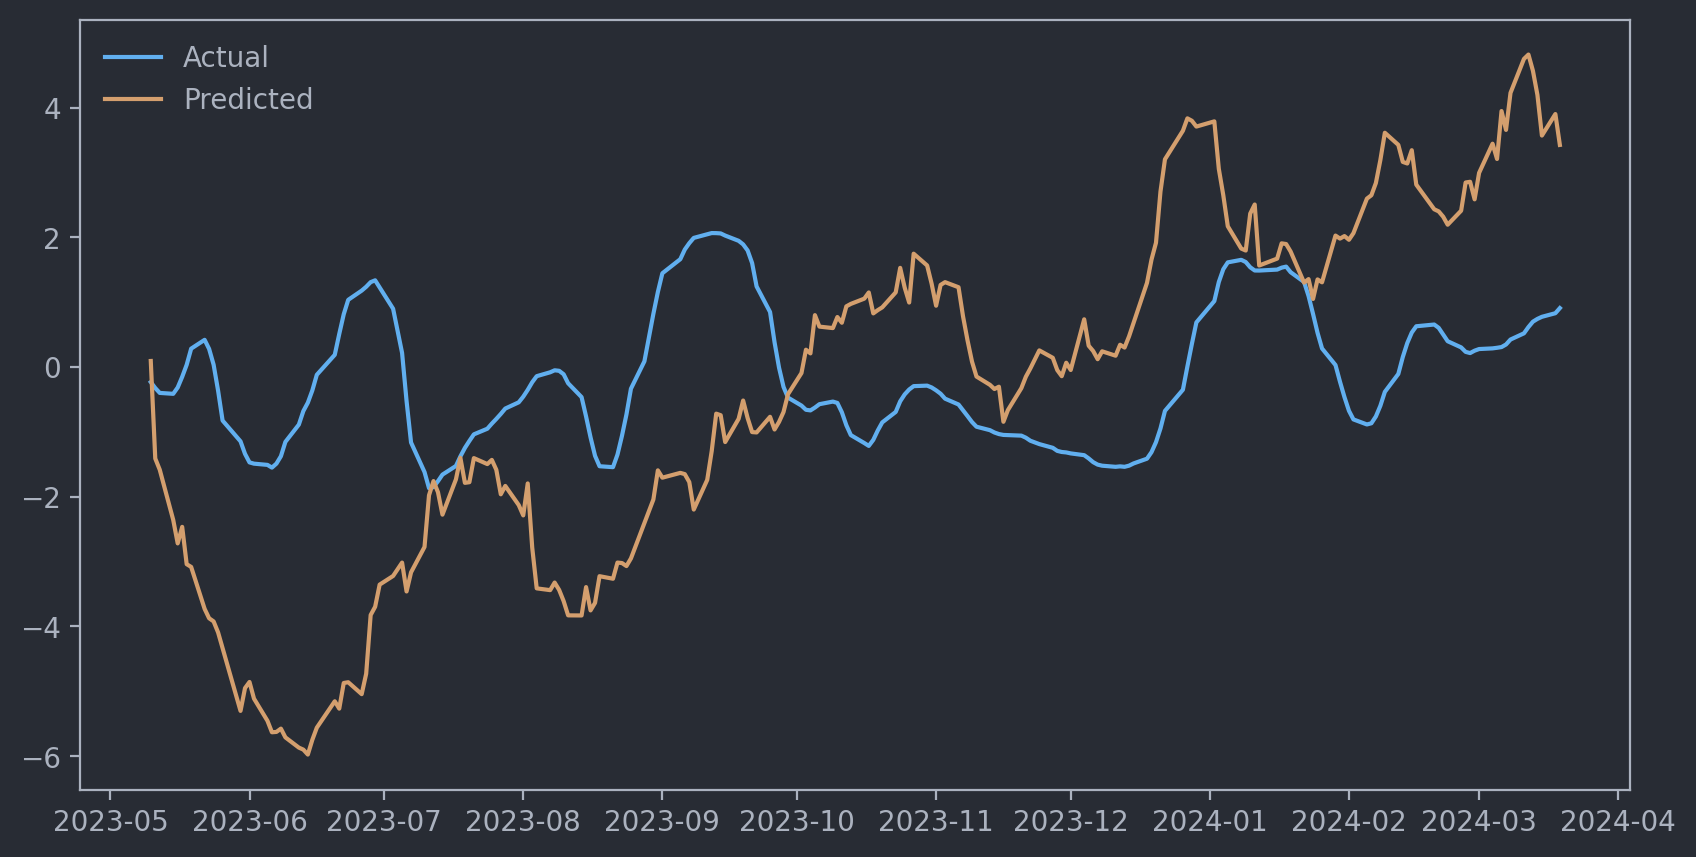

/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

R2: -0.21, MAE: 0.95, MAPE: 178.37%


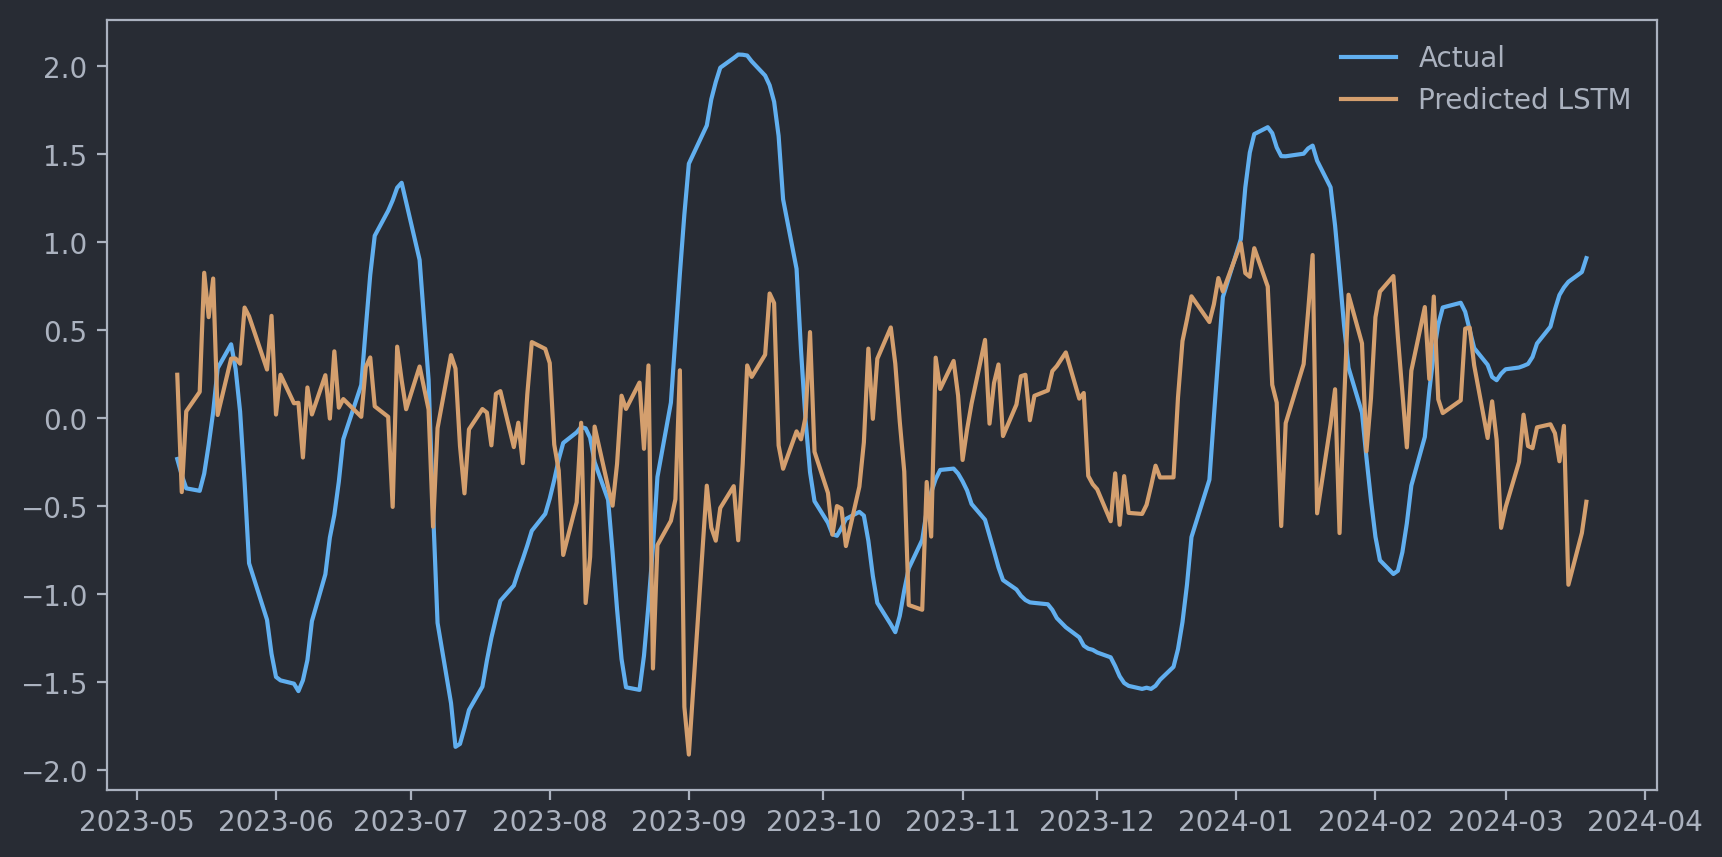

/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step

R2: -0.14, MAE: 0.95, MAPE: 160.87%


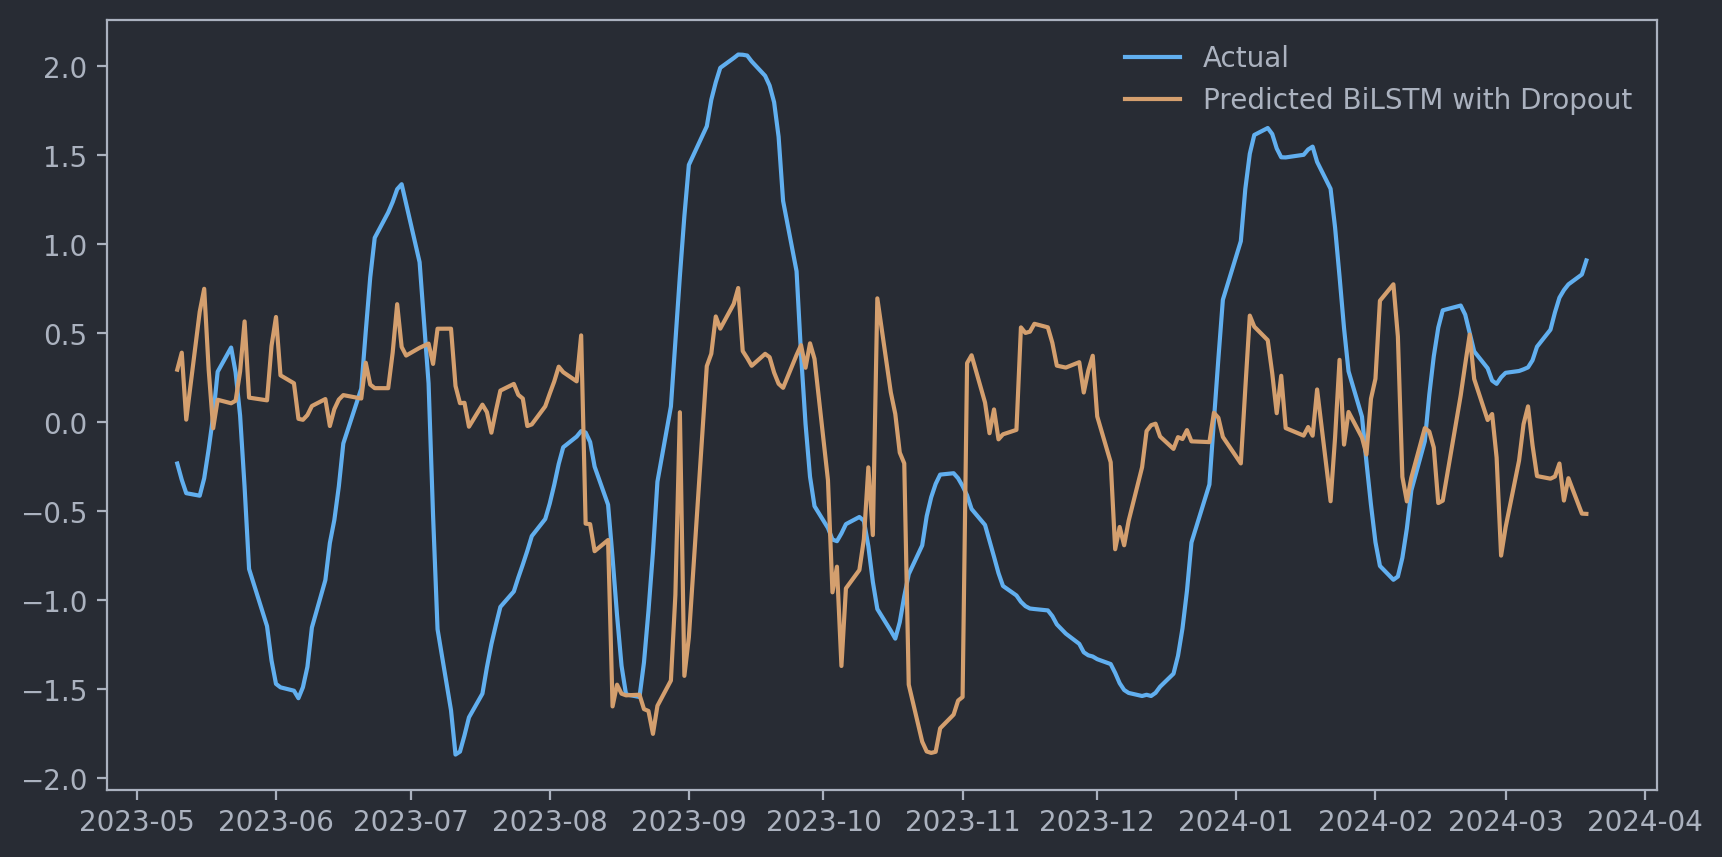

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout



model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

# Pad both training and testing feature sets
X_train_padded = np.pad(X_train.values, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test.values, ((0, 0), (0, padding_test)), 'constant', constant_values=0)

# Reshape both sets for LSTM
X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))


# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_lstm.fit(X_train_lstm, y_train, epochs=200, validation_split=0.1, verbose=0)

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Evaluate
model_results['LSTM'] = calculate_metrics(y_test, y_pred_lstm.flatten())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
plt.legend()
plt.show()


# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),  # Dropout for regularizing and preventing overfitting
    Bidirectional(LSTM(50)),
    Dropout(0.2),  # Another dropout layer after the second LSTM layer
    Dense(1)  # Output layer
])

model_bilstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_bilstm.fit(X_train_lstm, y_train, epochs=200, validation_split=0.1, verbose=0)

# Predict
y_pred_bilstm = model_bilstm.predict(X_test_lstm)

# Evaluate
model_results['BiLSTM with Dropout'] = calculate_metrics(y_test, y_pred_bilstm.flatten())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
plt.legend()
plt.show()



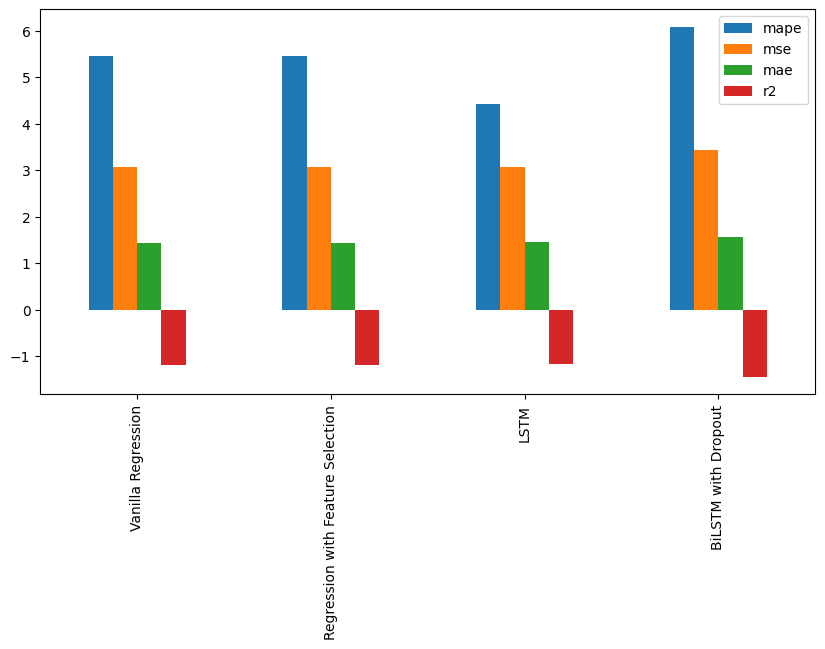

In [33]:
# elvaluate model results to dataframe and plot bar
model_results_df = pd.DataFrame(model_results).T
model_results_df.plot(kind='bar', figsize=(10, 5))
plt.show()


['GS' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -1.19, MAE: 1.42, MAPE: 544.56%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

R2: -1.26, MAE: 1.48, MAPE: 625.45%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

R2: -1.23, MAE: 1.49, MAPE: 504.56%


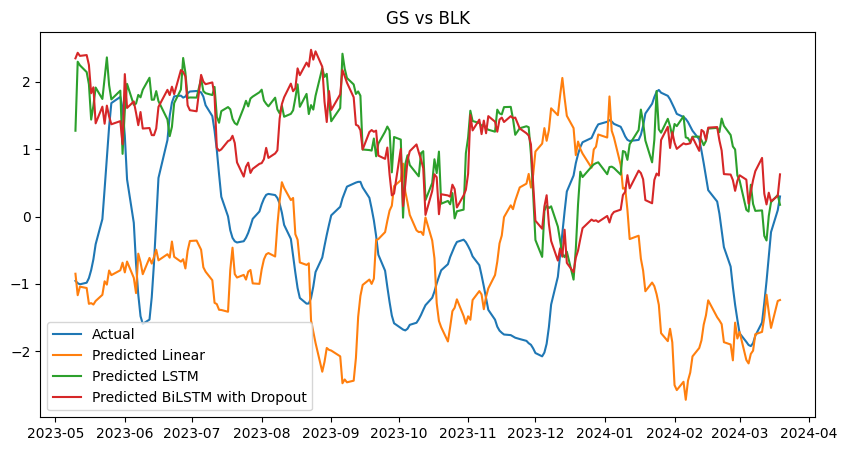

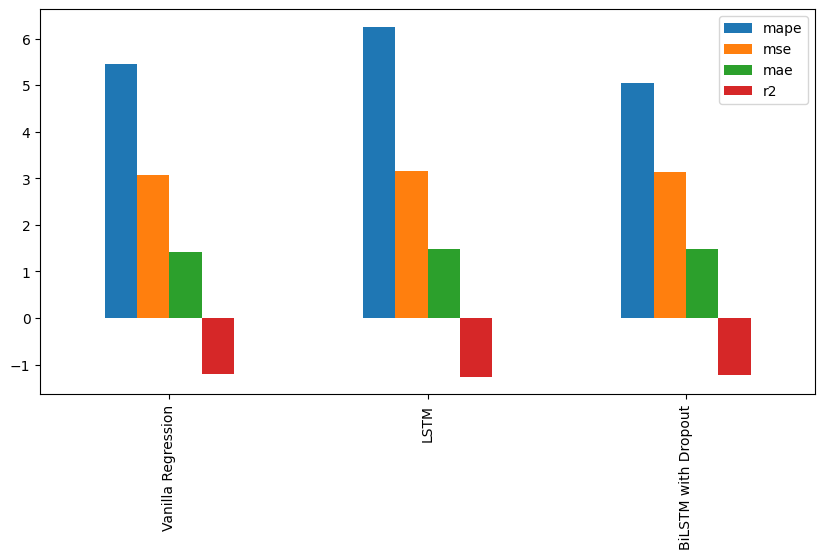

                         mape       mse       mae        r2
Vanilla Regression   5.445641  3.074472  1.422113 -1.194364
LSTM                 6.254463  3.162822  1.483748 -1.257423
BiLSTM with Dropout  5.045621  3.127679  1.492243 -1.232340
['JPM' 'CRM']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -6.05, MAE: 2.34, MAPE: 866.81%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

R2: -0.94, MAE: 1.24, MAPE: 264.91%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

R2: 0.07, MAE: 0.85, MAPE: 215.94%


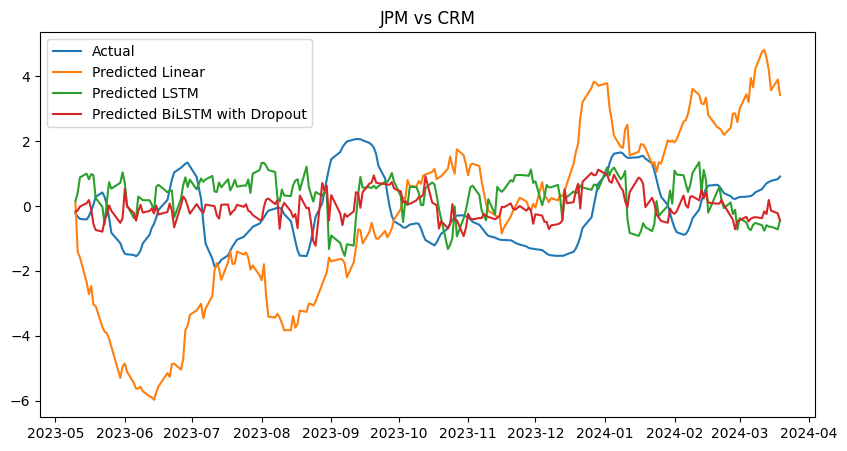

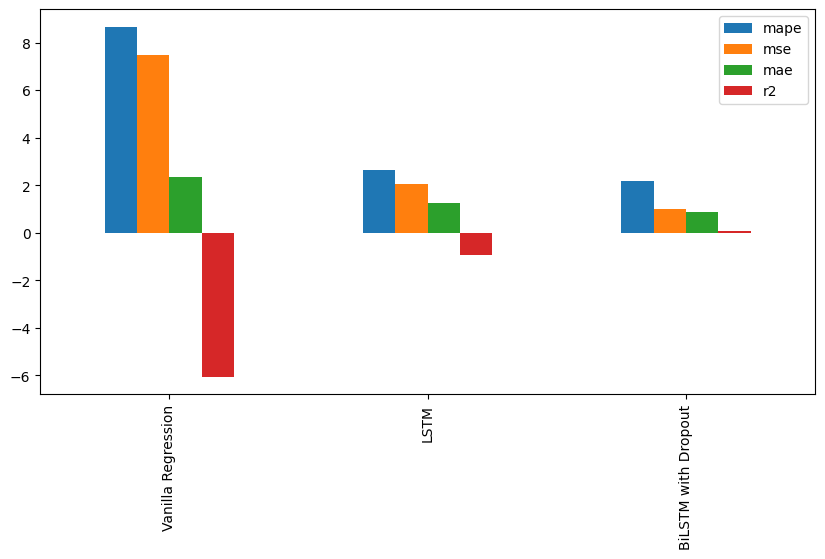

                         mape       mse       mae        r2
Vanilla Regression   8.668136  7.485987  2.341328 -6.049969
LSTM                 2.649078  2.059883  1.235427 -0.939906
BiLSTM with Dropout  2.159363  0.990344  0.853930  0.067338
['INTC' 'C']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -4.82, MAE: 2.29, MAPE: 893.78%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

R2: -0.48, MAE: 1.08, MAPE: 278.45%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

R2: -0.28, MAE: 0.99, MAPE: 384.32%


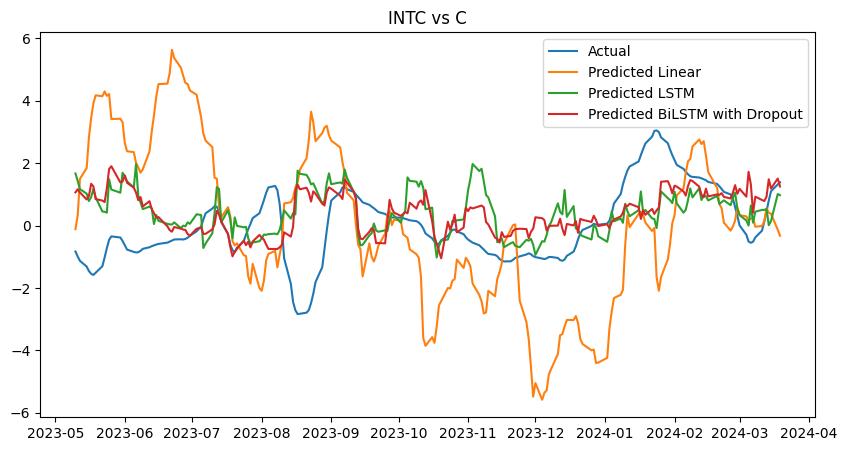

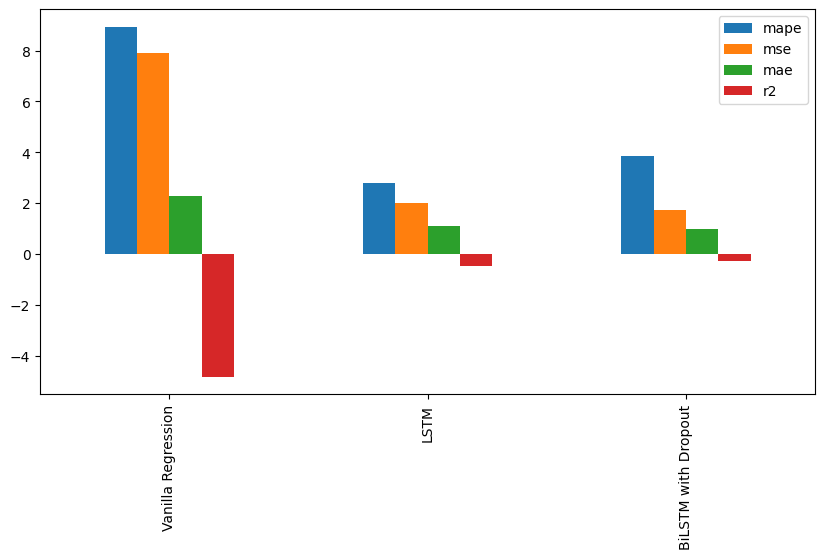

                         mape       mse       mae        r2
Vanilla Regression   8.937821  7.892333  2.293758 -4.822888
LSTM                 2.784513  2.010754  1.084192 -0.483515
BiLSTM with Dropout  3.843213  1.729552  0.992122 -0.276047
['WFC' 'UNP']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     445  2023-06-14
Val       127  2023-09-18
Test       65  2023-12-14

R2: -46538.30, MAE: 242.69, MAPE: 113845.93%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

R2: -0.27, MAE: 1.17, MAPE: 348.80%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

R2: -0.45, MAE: 1.22, MAPE: 483.93%


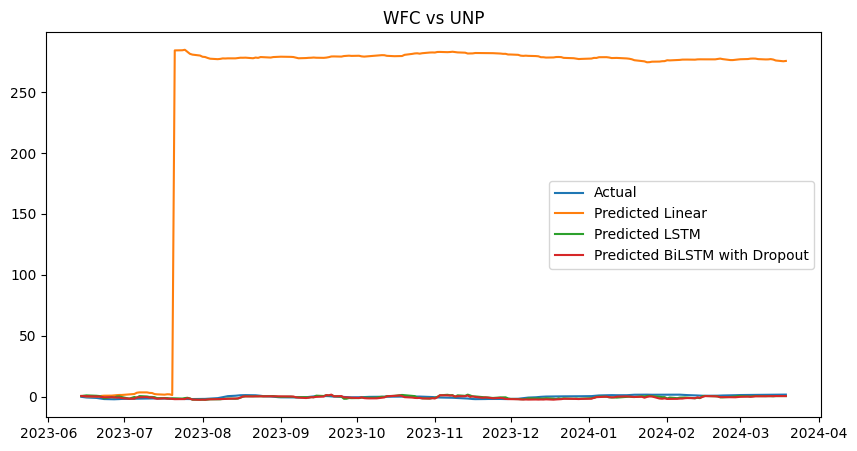

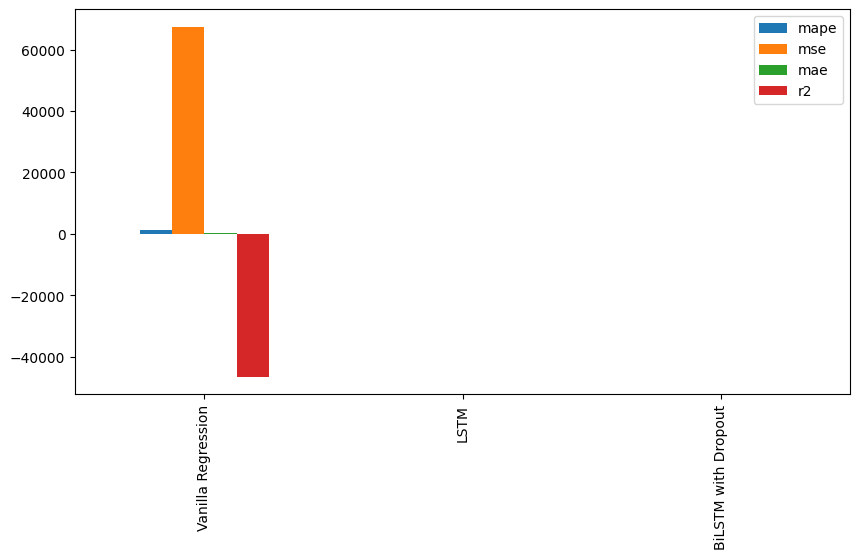

                            mape           mse         mae            r2
Vanilla Regression   1138.459295  67497.591994  242.686963 -46538.301435
LSTM                    3.487981      1.843893    1.167880     -0.271356
BiLSTM with Dropout     4.839274      2.097948    1.215283     -0.446526
['HON' 'GS']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -4.63, MAE: 2.28, MAPE: 473.53%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

R2: -0.09, MAE: 0.95, MAPE: 266.85%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: 0.00, MAE: 0.94, MAPE: 304.79%


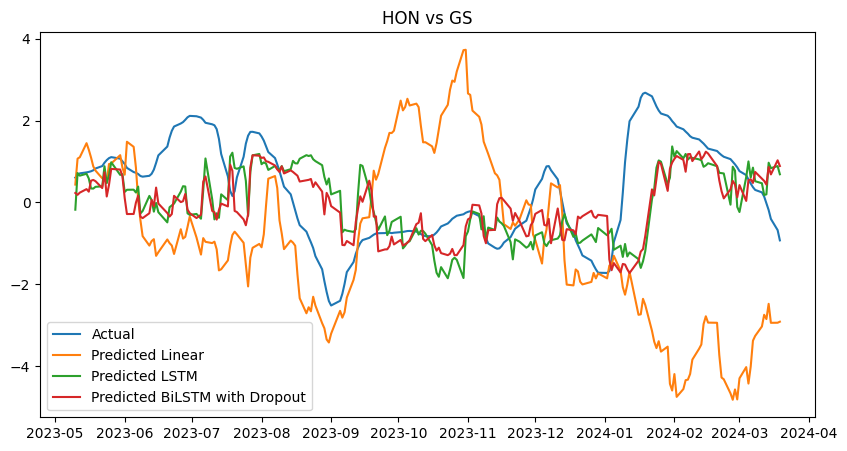

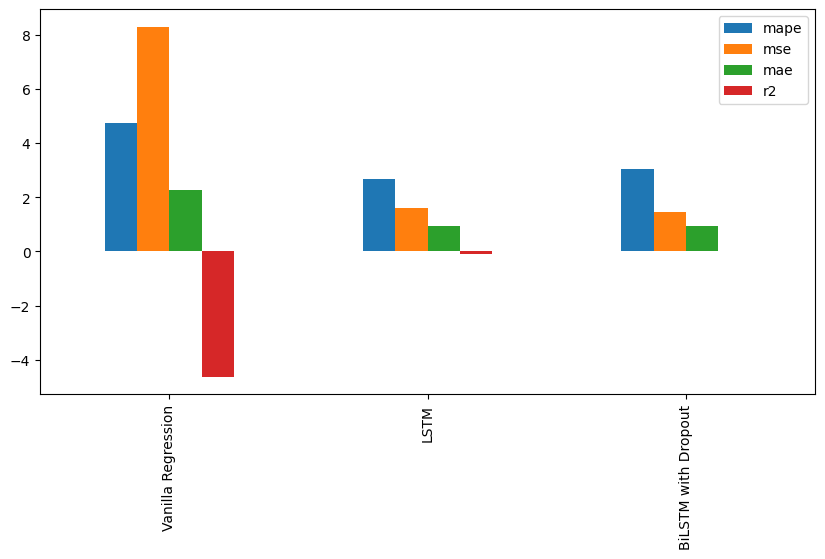

                         mape       mse       mae        r2
Vanilla Regression   4.735328  8.297835  2.281122 -4.626182
LSTM                 2.668543  1.601131  0.950272 -0.085615
BiLSTM with Dropout  3.047911  1.471942  0.936214  0.001979
['HON' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -33.32, MAE: 5.96, MAPE: 1547.19%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

R2: -0.68, MAE: 1.22, MAPE: 220.53%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

R2: -0.69, MAE: 1.12, MAPE: 221.89%


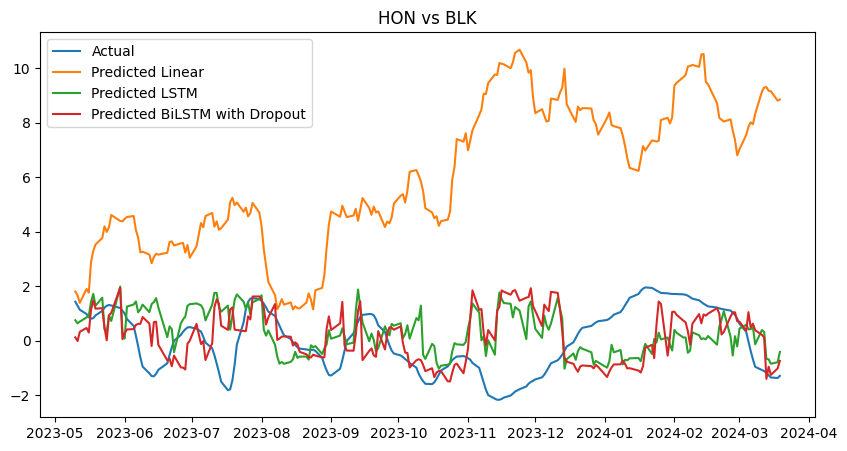

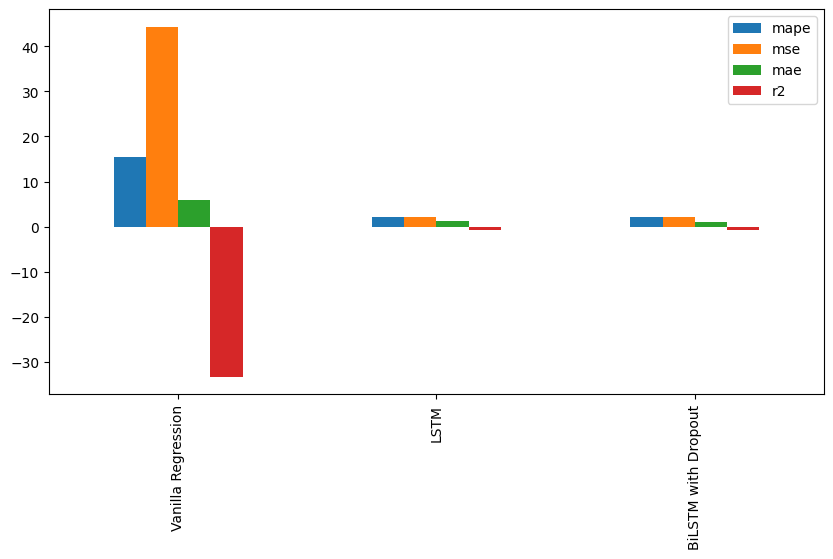

                          mape        mse       mae         r2
Vanilla Regression   15.471880  44.383749  5.959871 -33.321154
LSTM                  2.205290   2.176953  1.222836  -0.683398
BiLSTM with Dropout   2.218873   2.179189  1.115713  -0.685128
['JPM' 'GS']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -4.70, MAE: 2.22, MAPE: 591.62%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

R2: 0.09, MAE: 0.83, MAPE: 193.08%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

R2: 0.04, MAE: 0.83, MAPE: 182.10%


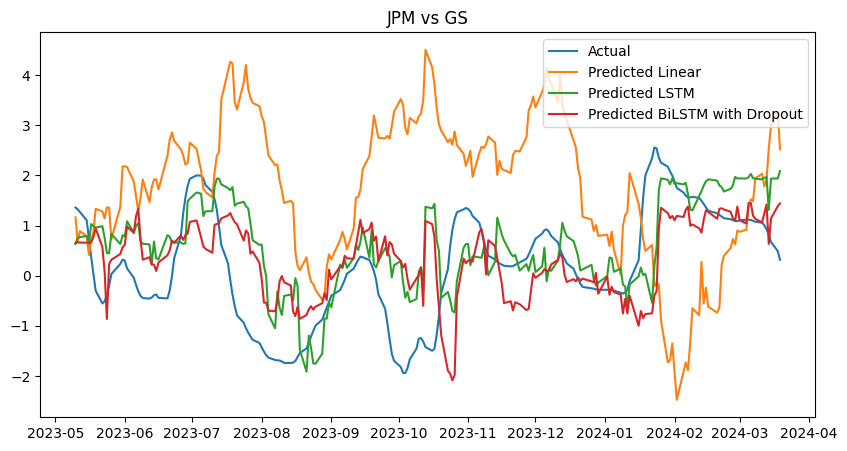

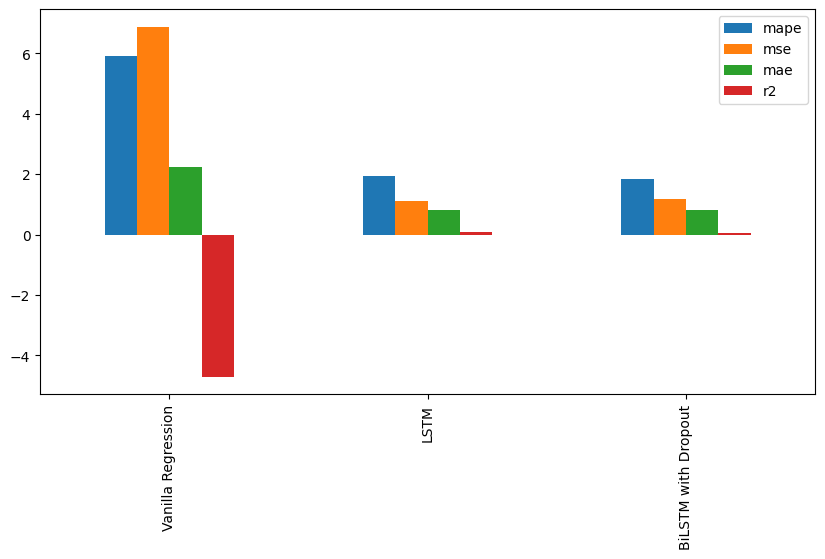

                         mape       mse       mae        r2
Vanilla Regression   5.916248  6.878102  2.217933 -4.703993
LSTM                 1.930751  1.097143  0.825646  0.090142
BiLSTM with Dropout  1.821000  1.163029  0.826685  0.035503
['WFC' 'AXP']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     443  2023-06-16
Val       126  2023-09-19
Test       64  2023-12-15

R2: -9.44, MAE: 3.19, MAPE: 969.03%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

R2: -0.12, MAE: 1.08, MAPE: 229.30%
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

R2: 0.05, MAE: 0.95, MAPE: 162.44%


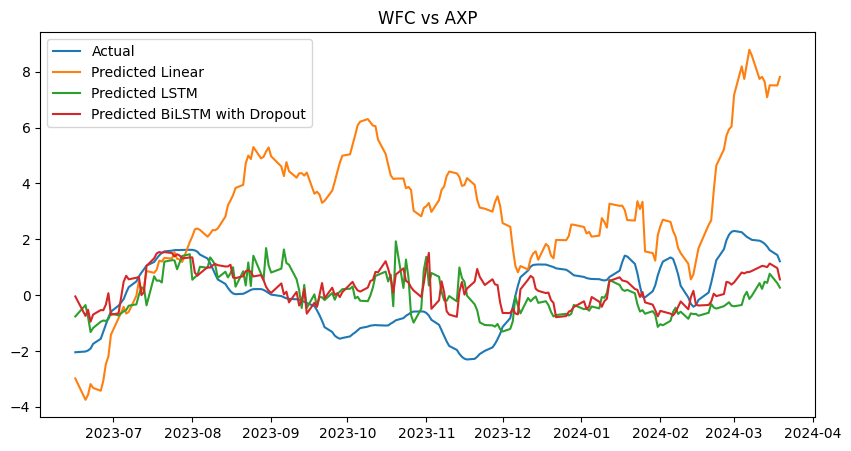

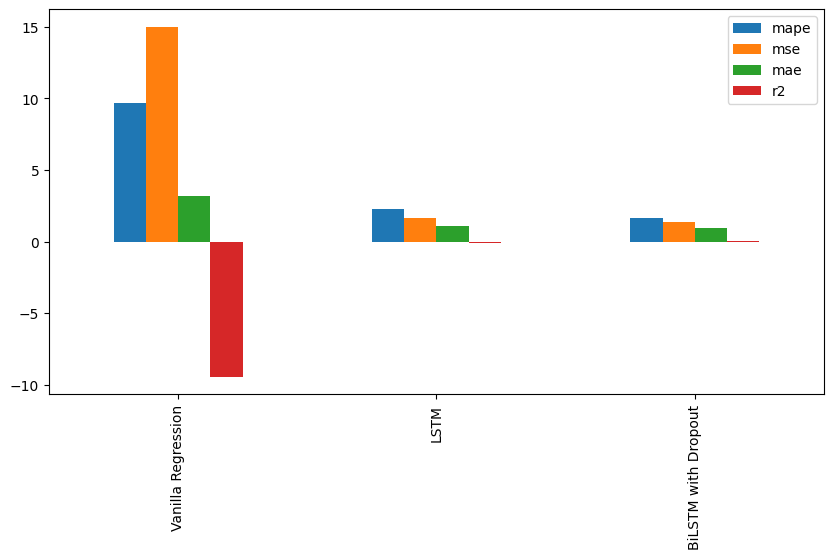

                         mape        mse       mae        r2
Vanilla Regression   9.690341  15.020034  3.189855 -9.441860
LSTM                 2.292986   1.611661  1.080433 -0.120419
BiLSTM with Dropout  1.624375   1.371506  0.953308  0.046535
['WFC' 'GS']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -3.84, MAE: 2.43, MAPE: 436.49%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

R2: -0.03, MAE: 1.06, MAPE: 149.49%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: 0.07, MAE: 0.98, MAPE: 127.77%


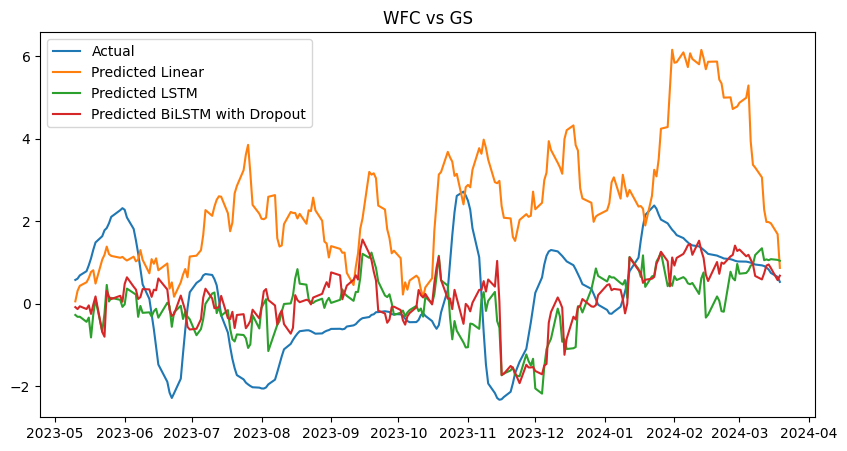

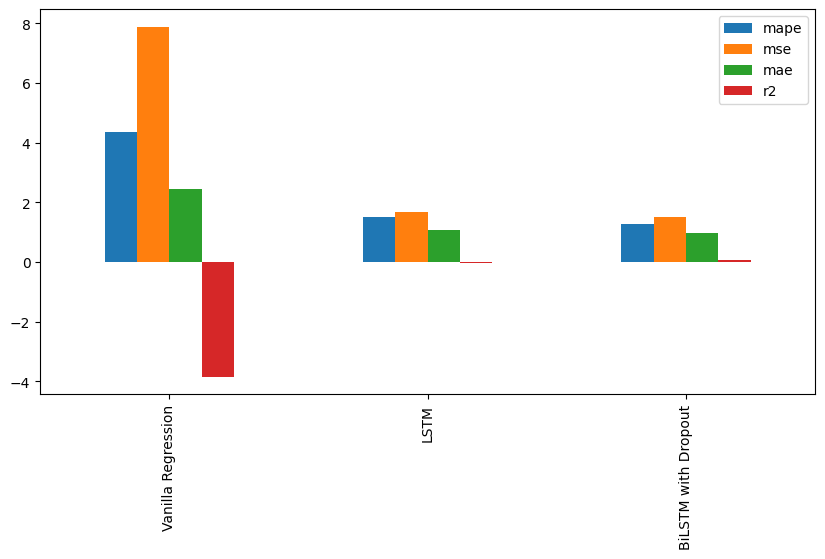

                         mape       mse       mae        r2
Vanilla Regression   4.364852  7.884375  2.430220 -3.842552
LSTM                 1.494944  1.678540  1.062032 -0.030952
BiLSTM with Dropout  1.277701  1.512319  0.982052  0.071139
['HON' 'C']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -3.80, MAE: 2.06, MAPE: 958.08%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: 0.10, MAE: 0.84, MAPE: 200.91%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: 0.08, MAE: 0.87, MAPE: 232.19%


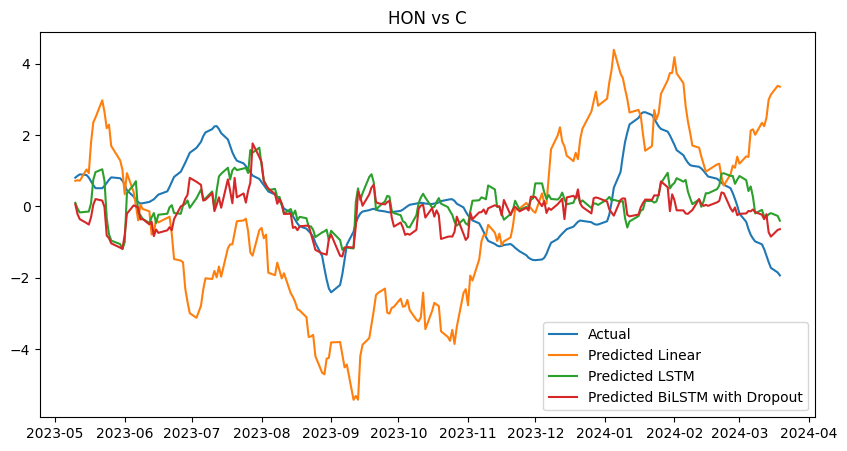

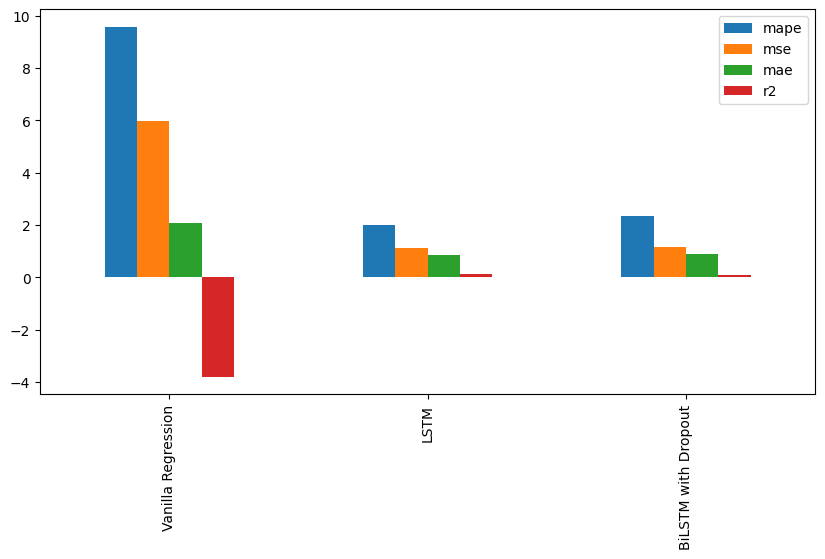

                         mape       mse       mae        r2
Vanilla Regression   9.580779  5.966040  2.055114 -3.802636
LSTM                 2.009149  1.112256  0.838399  0.104638
BiLSTM with Dropout  2.321949  1.140305  0.871314  0.082059
['C' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -14.66, MAE: 3.26, MAPE: 885.88%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

R2: -0.16, MAE: 0.97, MAPE: 261.72%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: -0.25, MAE: 1.08, MAPE: 419.52%


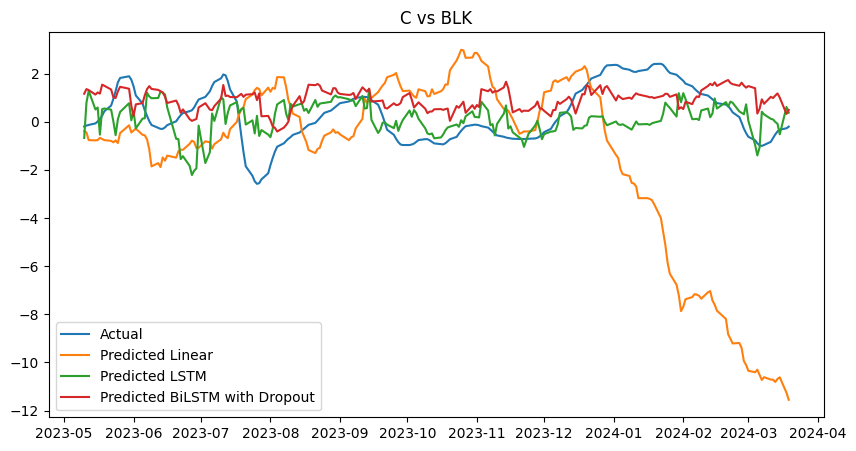

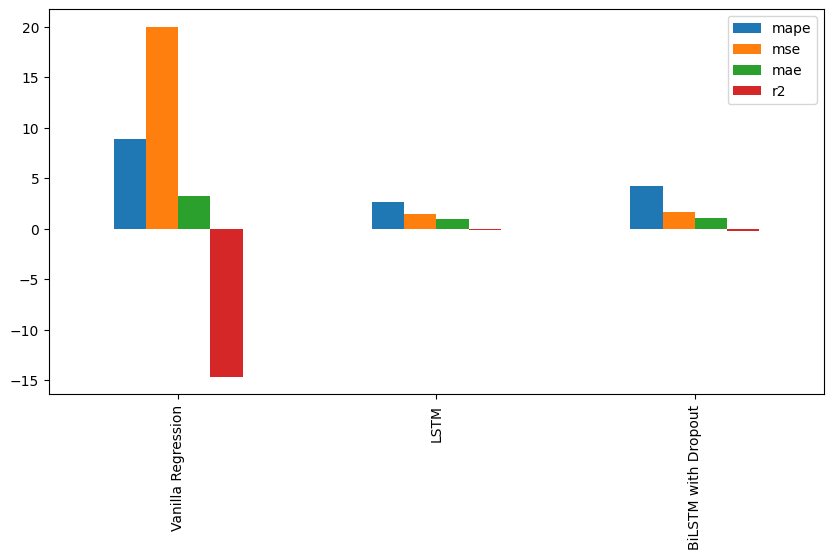

                         mape        mse       mae         r2
Vanilla Regression   8.858773  19.986288  3.258474 -14.660716
LSTM                 2.617178   1.483060  0.974040  -0.162086
BiLSTM with Dropout  4.195165   1.590217  1.080695  -0.246051
['UNP' 'AXP']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     443  2023-06-16
Val       126  2023-09-19
Test       64  2023-12-15

R2: -957411629433659267743744.00, MAE: 1081496912412.74, MAPE: 308593398511336.56%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

R2: -0.36, MAE: 1.12, MAPE: 178.08%
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

R2: -0.35, MAE: 1.08, MAPE: 208.94%


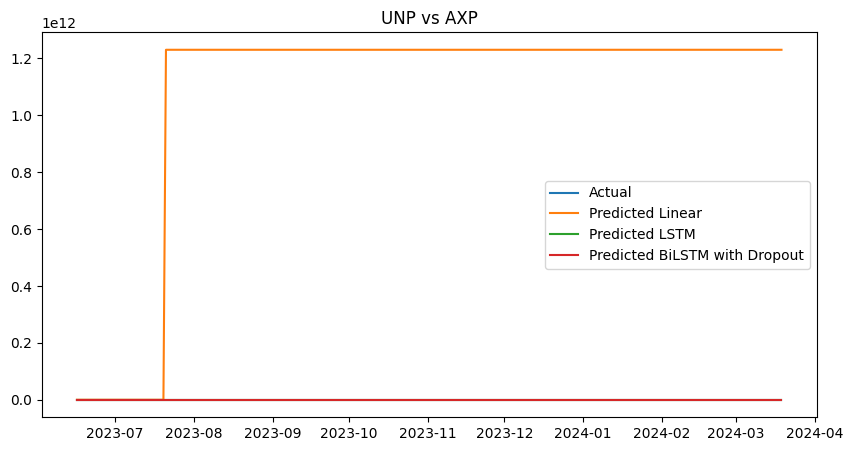

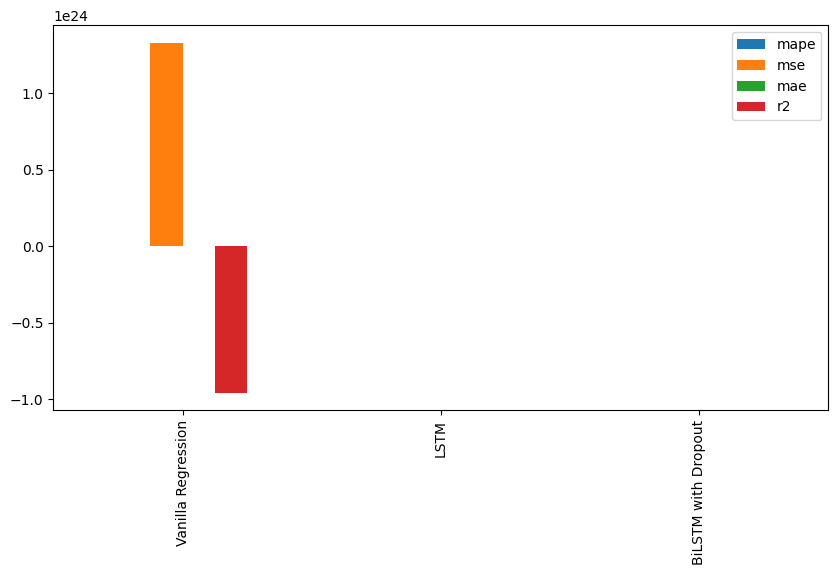

                             mape           mse           mae            r2
Vanilla Regression   3.085934e+12  1.330723e+24  1.081497e+12 -9.574116e+23
LSTM                 1.780753e+00  1.893527e+00  1.122319e+00 -3.623303e-01
BiLSTM with Dropout  2.089447e+00  1.870696e+00  1.076768e+00 -3.459043e-01
['WFC' 'MS']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -3.25, MAE: 2.05, MAPE: 282.02%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

R2: 0.11, MAE: 0.93, MAPE: 162.95%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

R2: 0.10, MAE: 0.93, MAPE: 153.29%


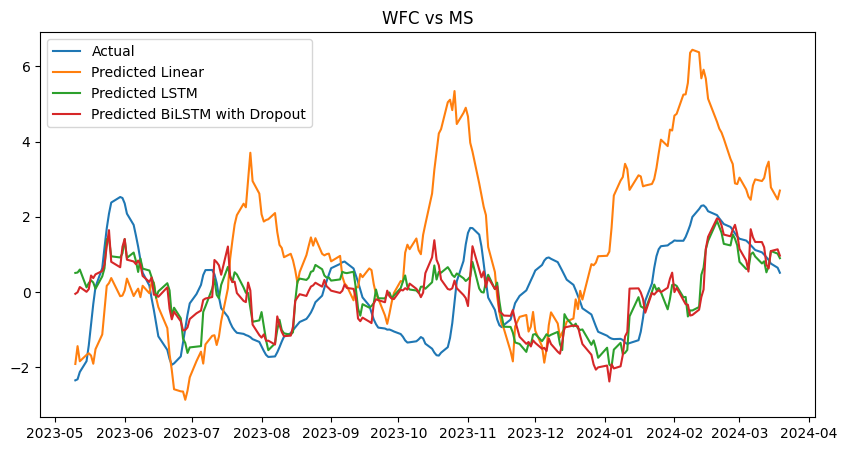

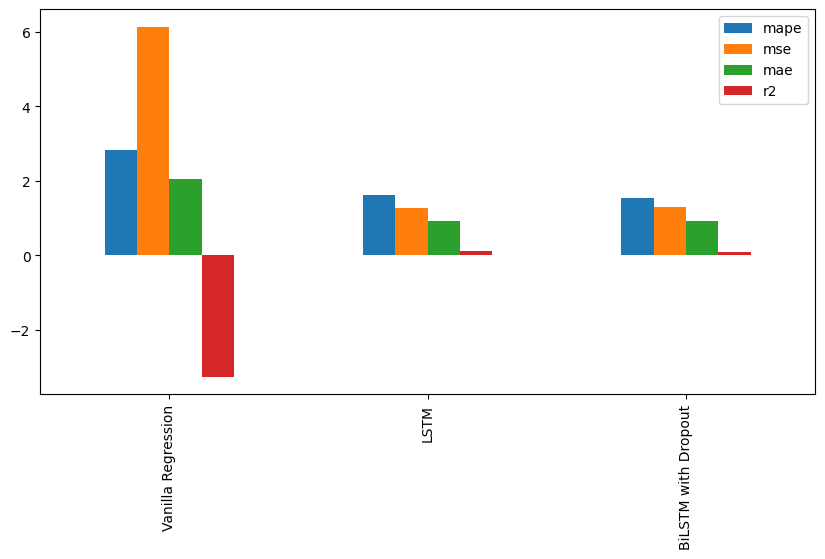

                         mape       mse       mae        r2
Vanilla Regression   2.820213  6.134672  2.054552 -3.253138
LSTM                 1.629484  1.280157  0.928369  0.112474
BiLSTM with Dropout  1.532852  1.300314  0.928842  0.098498
['UNP' 'GOOGL']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     445  2023-06-14
Val       127  2023-09-18
Test       65  2023-12-14

R2: -764767.83, MAE: 900.92, MAPE: 254761.77%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

R2: -0.09, MAE: 0.96, MAPE: 181.33%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

R2: -0.23, MAE: 0.97, MAPE: 184.15%


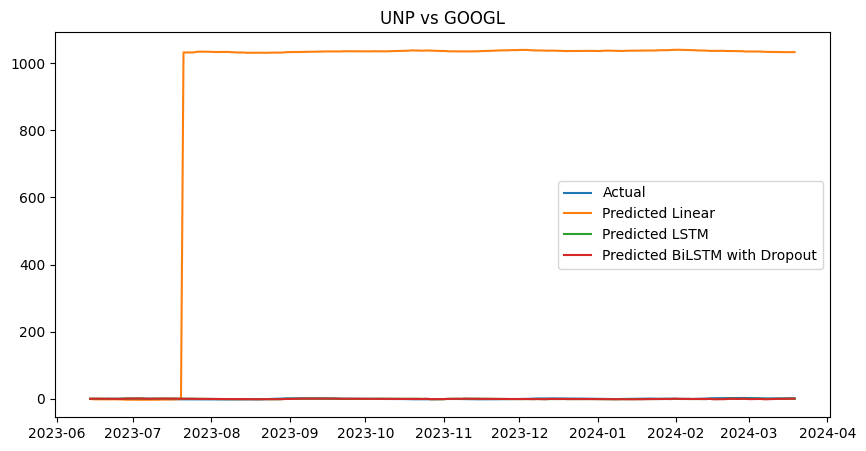

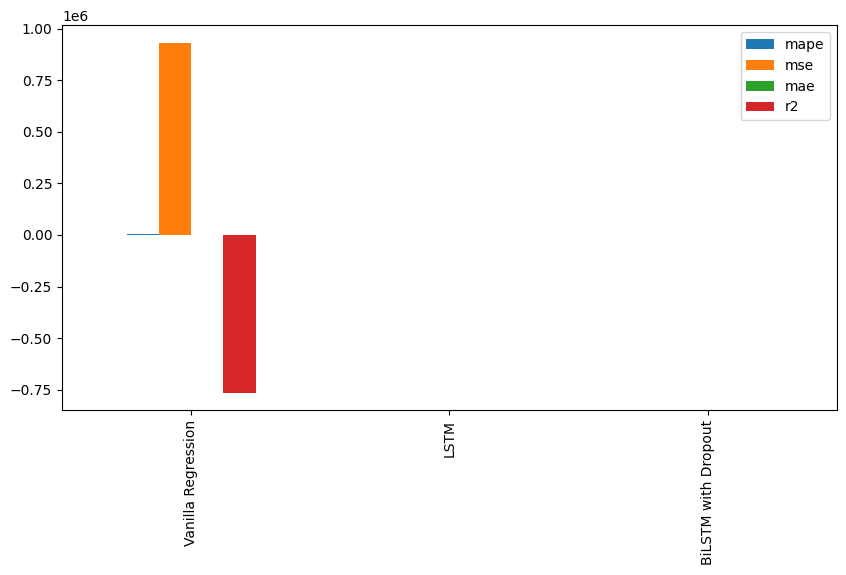

                            mape            mse         mae             r2
Vanilla Regression   2547.617722  932682.791354  900.920226 -764767.833537
LSTM                    1.813278       1.330261    0.956866      -0.090769
BiLSTM with Dropout     1.841498       1.494024    0.974495      -0.225050
['INTC' 'FDX']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -3.39, MAE: 1.96, MAPE: 961.27%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

R2: -0.25, MAE: 1.07, MAPE: 288.22%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: -0.12, MAE: 1.04, MAPE: 285.12%


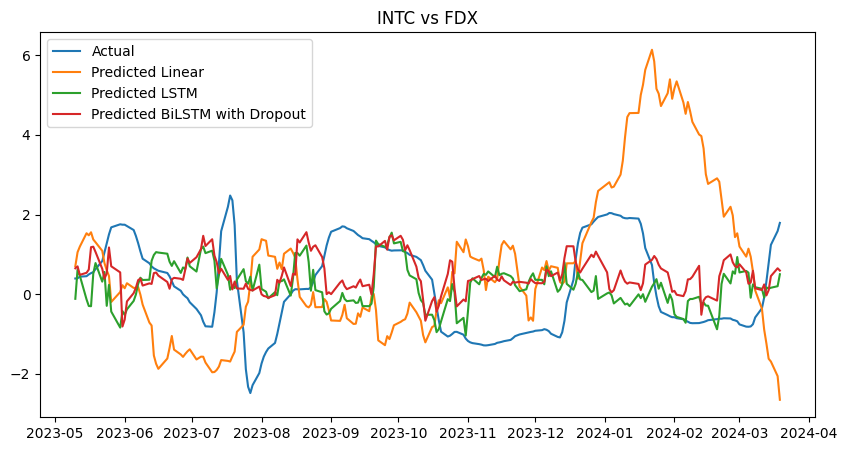

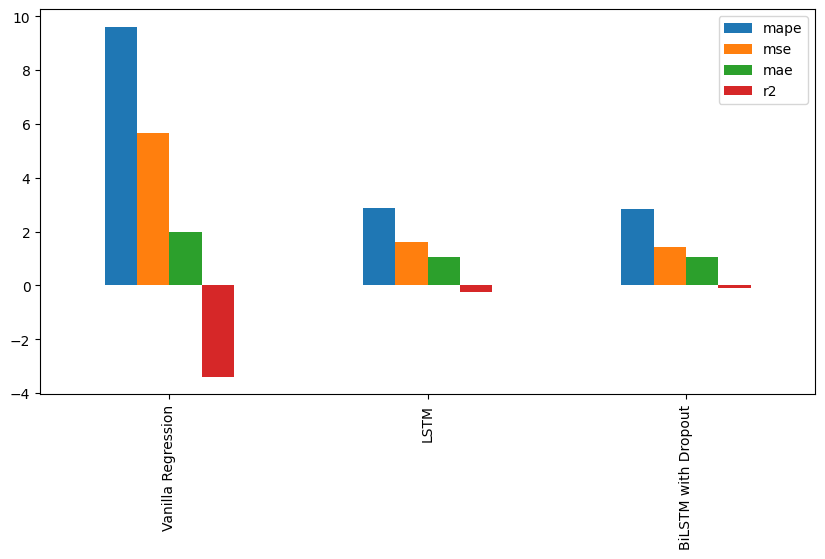

                         mape       mse       mae        r2
Vanilla Regression   9.612688  5.660892  1.963862 -3.392801
LSTM                 2.882211  1.615044  1.069097 -0.253259
BiLSTM with Dropout  2.851182  1.438995  1.042316 -0.116647
['C' 'BAC']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -23.27, MAE: 3.96, MAPE: 2482.51%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: 0.25, MAE: 0.66, MAPE: 156.89%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

R2: 0.35, MAE: 0.64, MAPE: 285.87%


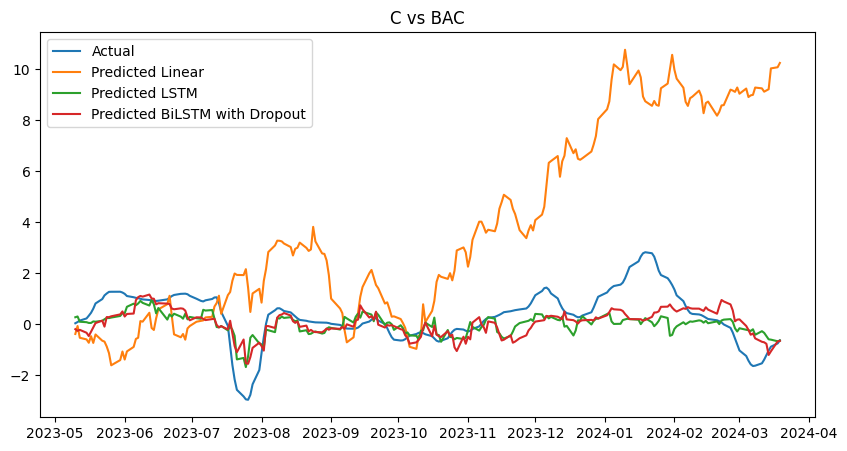

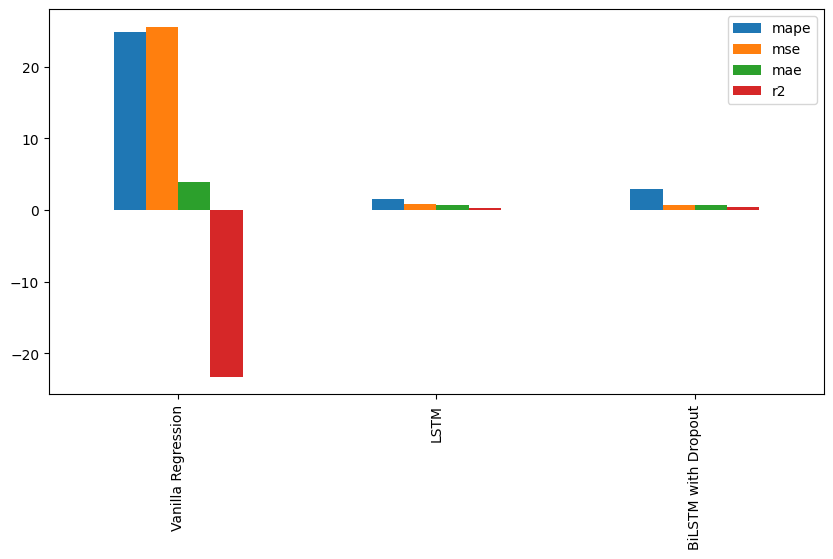

                          mape        mse       mae         r2
Vanilla Regression   24.825131  25.586334  3.955208 -23.270959
LSTM                  1.568909   0.791542  0.664825   0.249151
BiLSTM with Dropout   2.858745   0.687991  0.635581   0.347378
['JPM' 'GOOGL']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -3.44, MAE: 1.91, MAPE: 538.84%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

R2: 0.22, MAE: 0.75, MAPE: 195.54%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

R2: 0.18, MAE: 0.82, MAPE: 321.90%


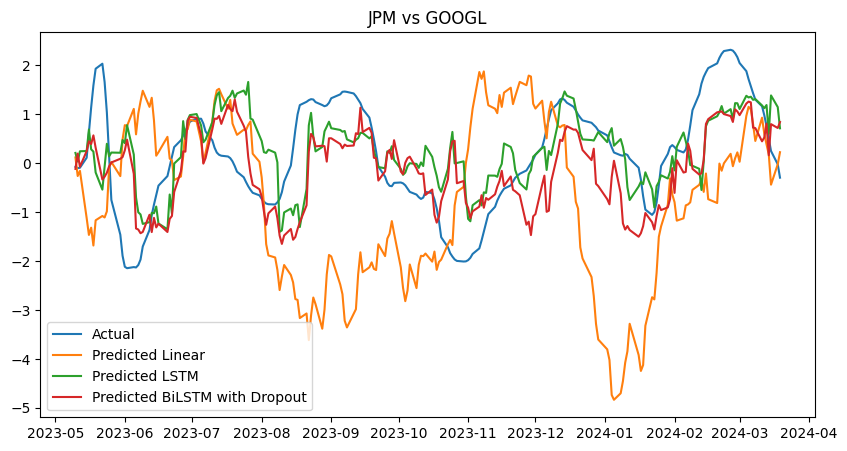

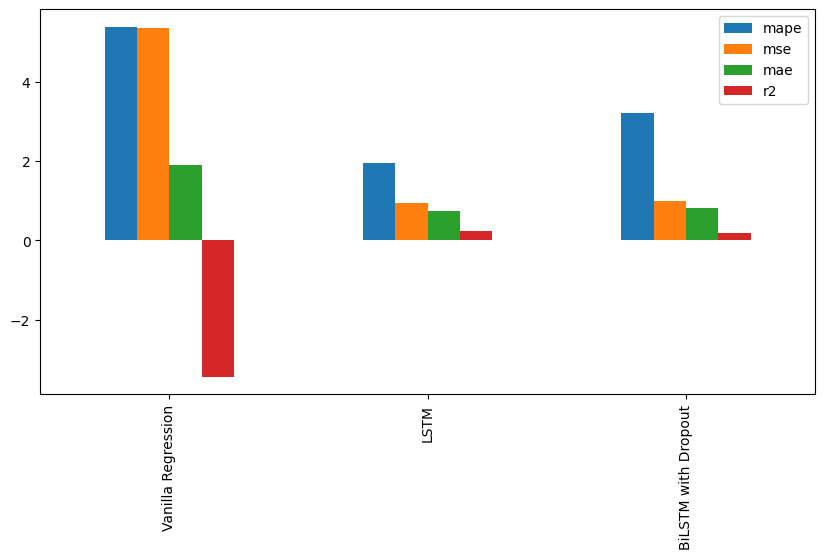

                         mape       mse       mae        r2
Vanilla Regression   5.388364  5.353548  1.910127 -3.439555
LSTM                 1.955446  0.936716  0.750179  0.223207
BiLSTM with Dropout  3.219042  0.988132  0.815612  0.180568
['INTC' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -4.25, MAE: 2.03, MAPE: 687.74%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: -0.65, MAE: 1.15, MAPE: 276.72%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

R2: -0.88, MAE: 1.20, MAPE: 334.39%


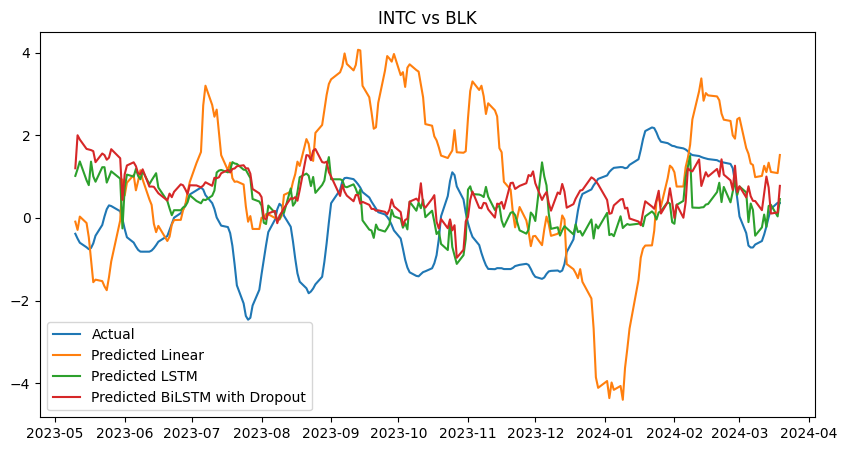

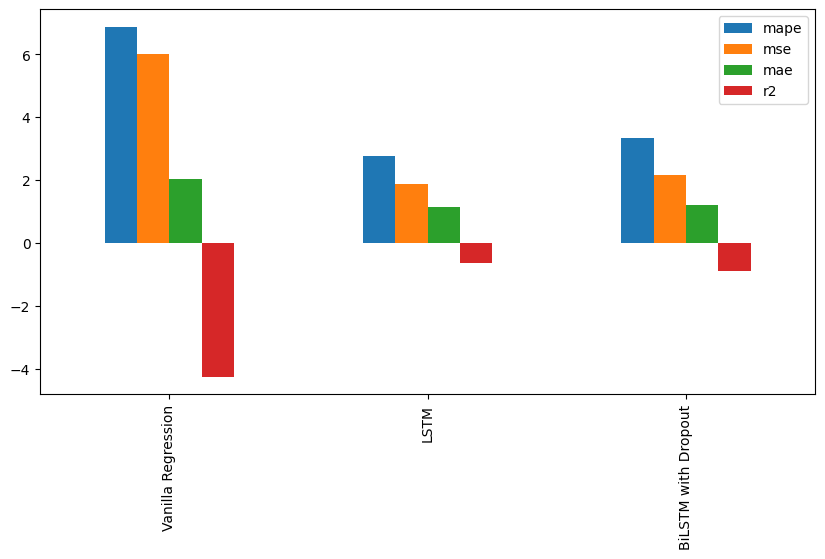

                         mape       mse       mae        r2
Vanilla Regression   6.877368  6.011332  2.026080 -4.254068
LSTM                 2.767234  1.887000  1.145463 -0.649289
BiLSTM with Dropout  3.343885  2.154049  1.200962 -0.882697
['MS' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -28.85, MAE: 5.16, MAPE: 1017.76%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

R2: -1.63, MAE: 1.41, MAPE: 310.51%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

R2: -1.47, MAE: 1.38, MAPE: 293.55%


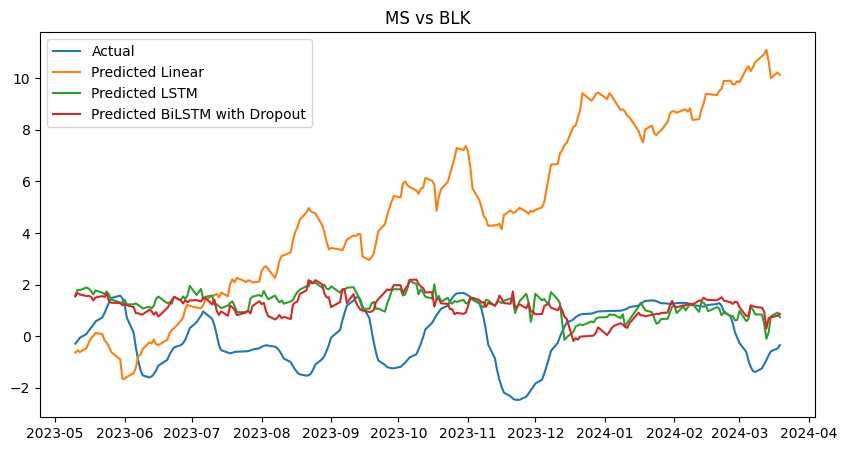

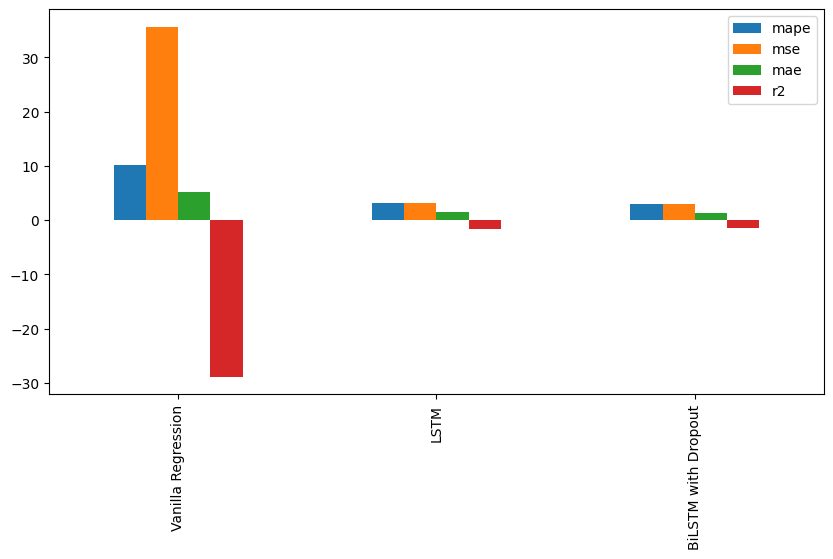

                          mape        mse       mae         r2
Vanilla Regression   10.177602  35.634941  5.163050 -28.850922
LSTM                  3.105128   3.145232  1.407044  -1.634720
BiLSTM with Dropout   2.935543   2.951012  1.383726  -1.472024
['MS' 'GS']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -5.05, MAE: 2.16, MAPE: 1205.54%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

R2: 0.00, MAE: 0.90, MAPE: 289.04%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

R2: 0.18, MAE: 0.81, MAPE: 214.92%


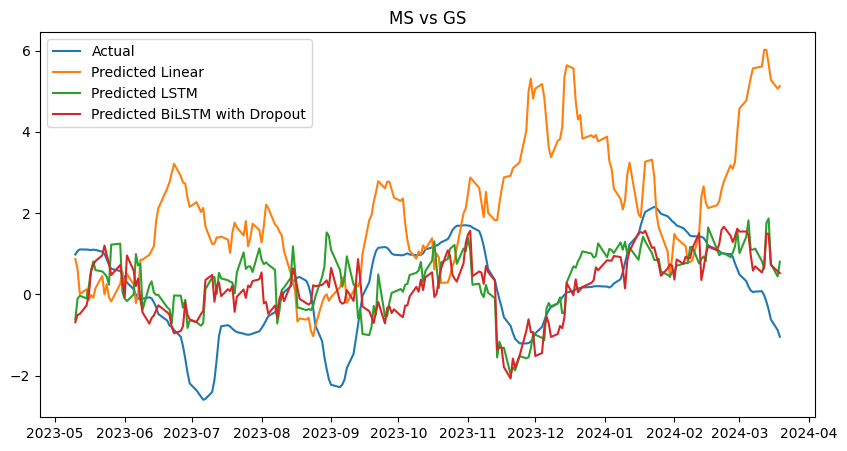

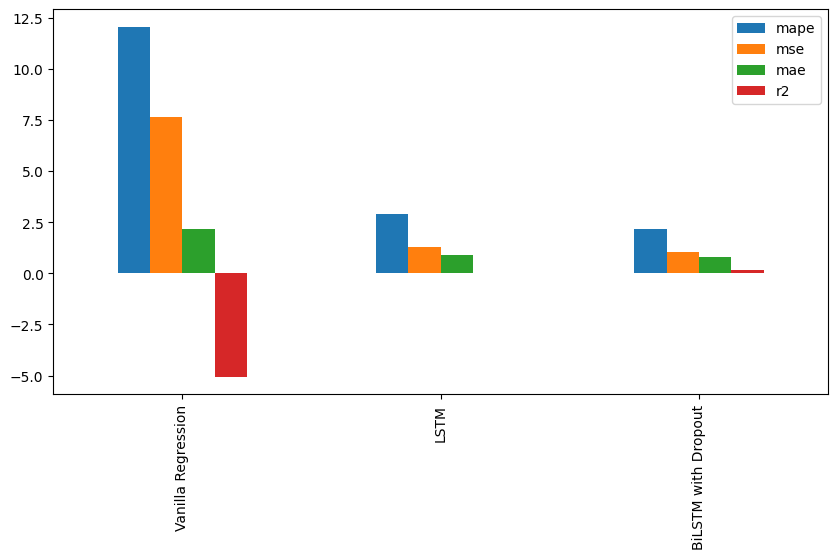

                          mape       mse       mae        r2
Vanilla Regression   12.055387  7.647906  2.161297 -5.050648
LSTM                  2.890393  1.263403  0.900542  0.000457
BiLSTM with Dropout   2.149248  1.030552  0.811077  0.184678
['CRM' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -30.27, MAE: 5.21, MAPE: 995.49%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

R2: 0.26, MAE: 0.73, MAPE: 135.58%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

R2: -0.12, MAE: 0.94, MAPE: 180.69%


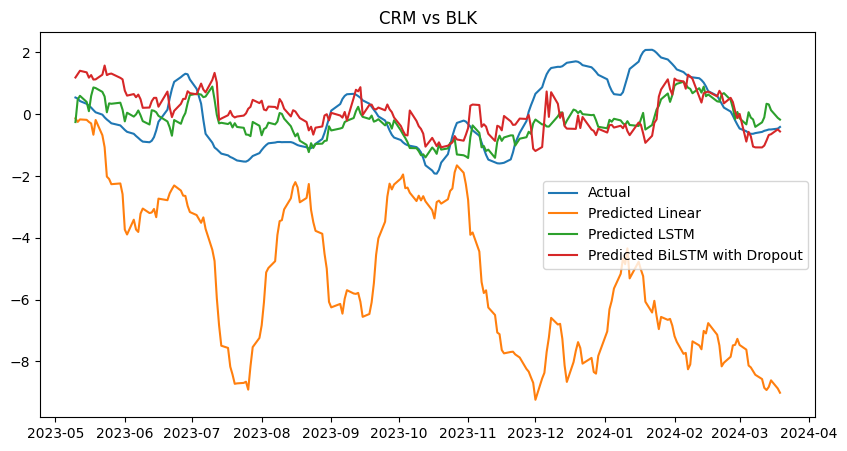

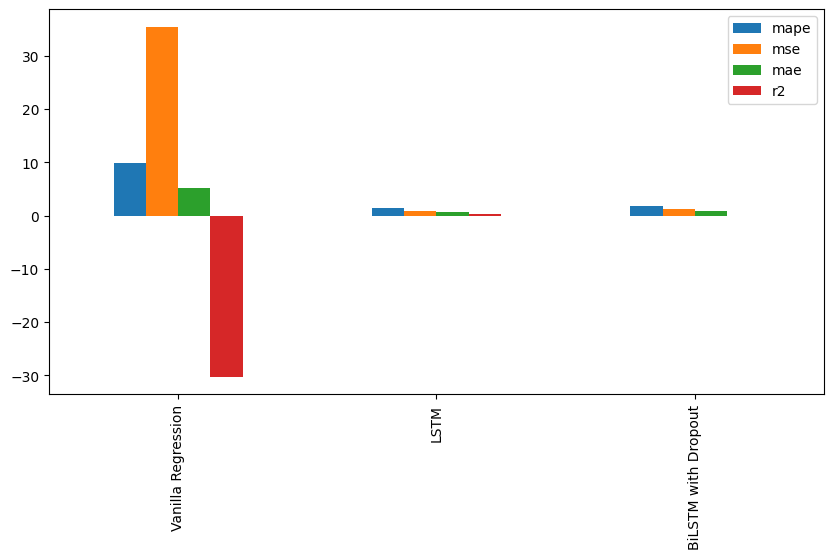

                         mape        mse       mae         r2
Vanilla Regression   9.954936  35.478303  5.209719 -30.271273
LSTM                 1.355807   0.835166  0.733458   0.263869
BiLSTM with Dropout  1.806860   1.272552  0.936808  -0.121652
['GOOGL' 'CRM']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -7.80, MAE: 2.26, MAPE: 1720.14%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

R2: 0.01, MAE: 0.81, MAPE: 650.75%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: 0.01, MAE: 0.84, MAPE: 917.89%


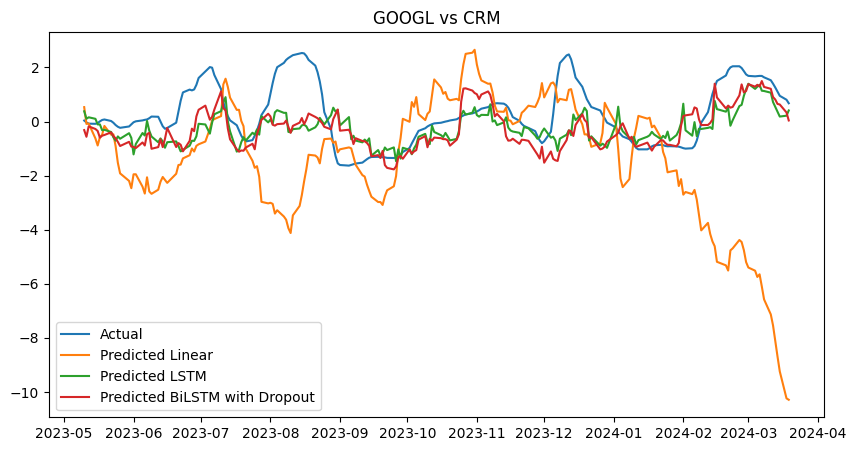

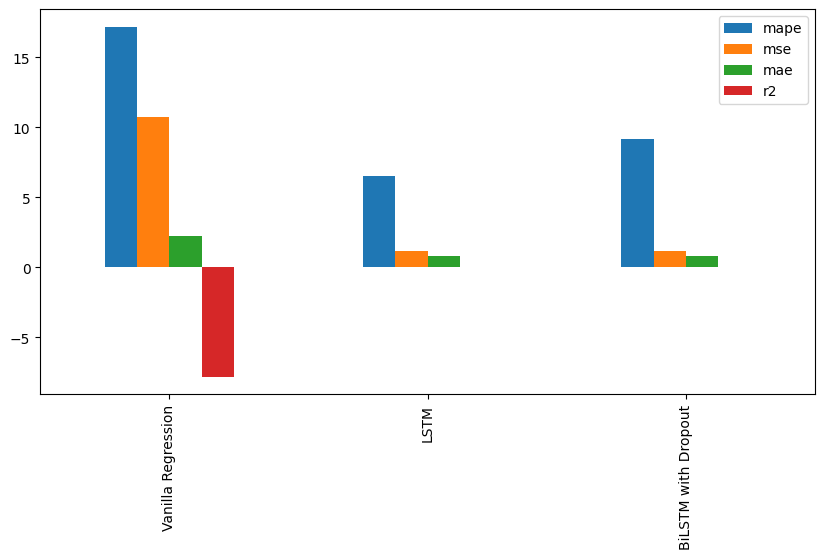

                          mape        mse       mae        r2
Vanilla Regression   17.201360  10.750468  2.260971 -7.801693
LSTM                  6.507530   1.204477  0.810322  0.013863
BiLSTM with Dropout   9.178914   1.206700  0.838305  0.012043
['INTC' 'HON']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -13.93, MAE: 3.86, MAPE: 711.76%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: -0.45, MAE: 1.21, MAPE: 211.28%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

R2: -0.62, MAE: 1.33, MAPE: 231.60%


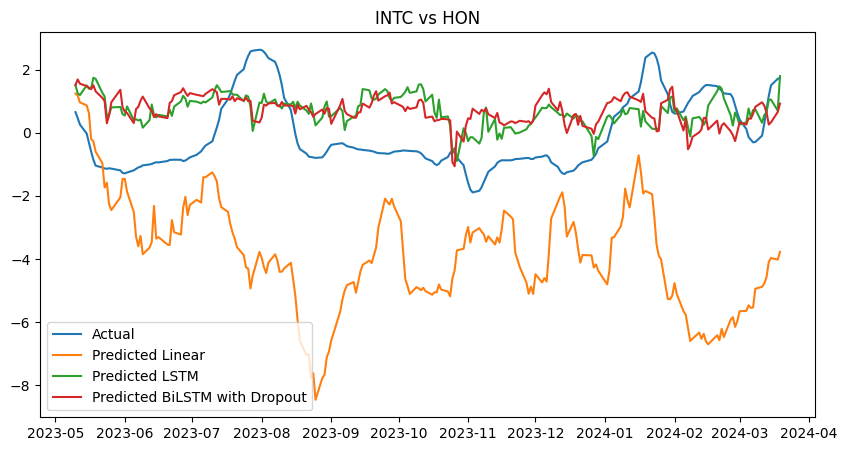

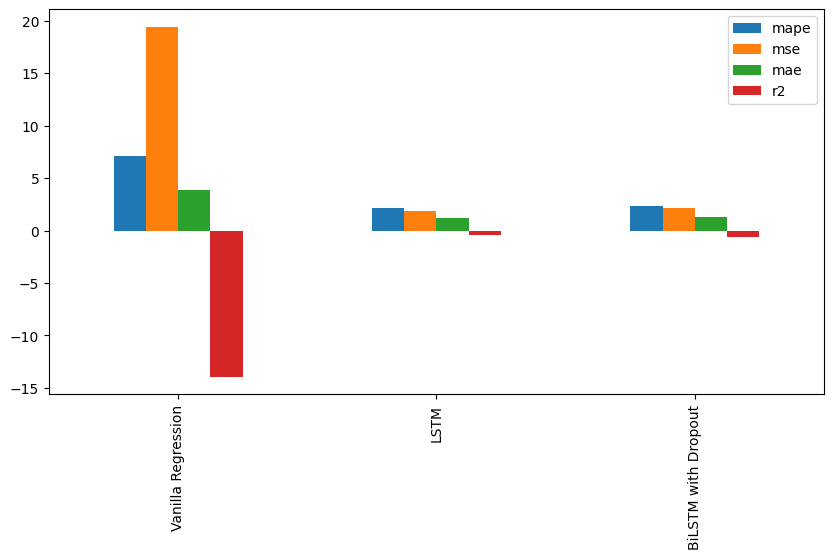

                         mape        mse       mae         r2
Vanilla Regression   7.117557  19.428713  3.862008 -13.926567
LSTM                 2.112802   1.887128  1.214839  -0.449830
BiLSTM with Dropout  2.315983   2.103962  1.327188  -0.616418
['GOOGL' 'AXP']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     443  2023-06-16
Val       126  2023-09-19
Test       64  2023-12-15

R2: -27.63, MAE: 5.74, MAPE: 1144.78%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

R2: -0.12, MAE: 1.01, MAPE: 179.26%
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

R2: 0.09, MAE: 0.90, MAPE: 168.83%


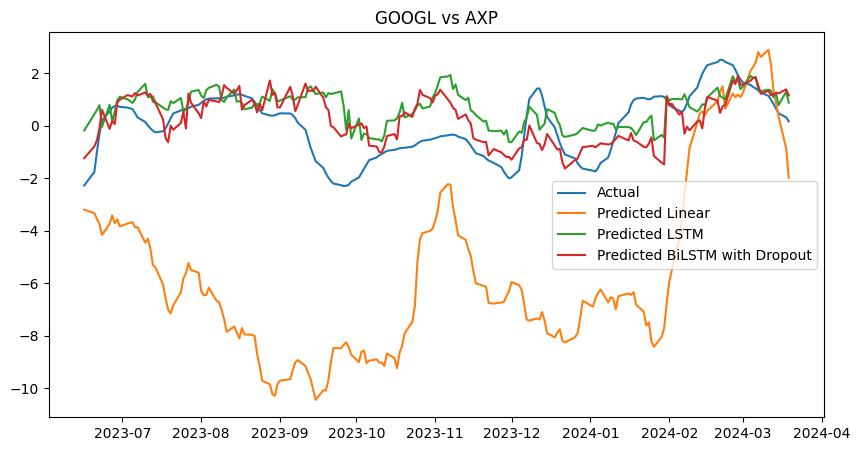

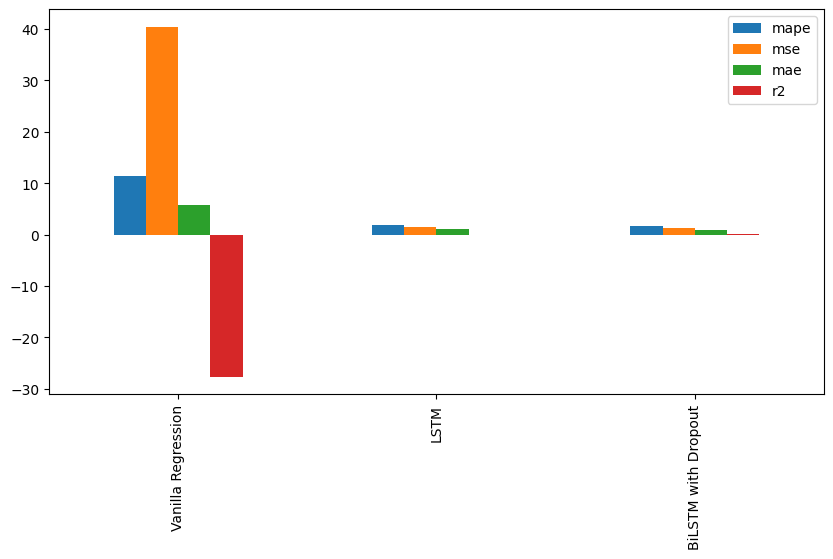

                          mape        mse       mae         r2
Vanilla Regression   11.447824  40.462848  5.741832 -27.630704
LSTM                  1.792614   1.579978  1.012532  -0.117961
BiLSTM with Dropout   1.688299   1.292288  0.898041   0.085603
['WFC' 'GOOGL']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -8.50, MAE: 3.09, MAPE: 2495.40%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

R2: 0.22, MAE: 0.76, MAPE: 313.17%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

R2: 0.33, MAE: 0.72, MAPE: 528.86%


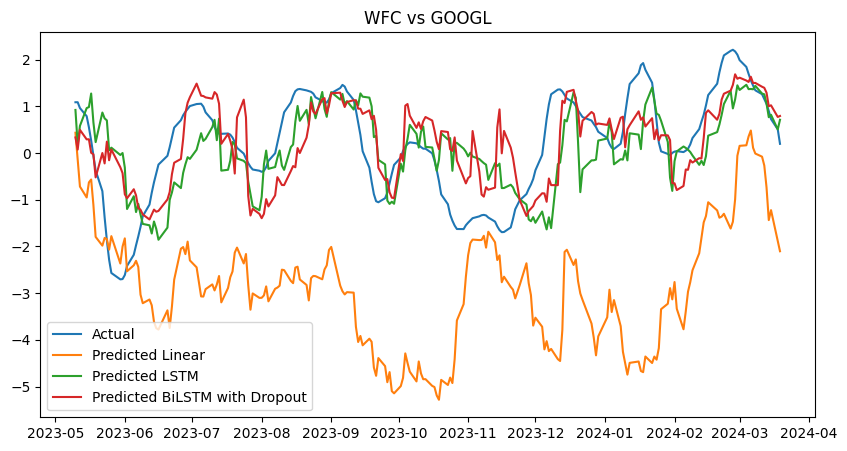

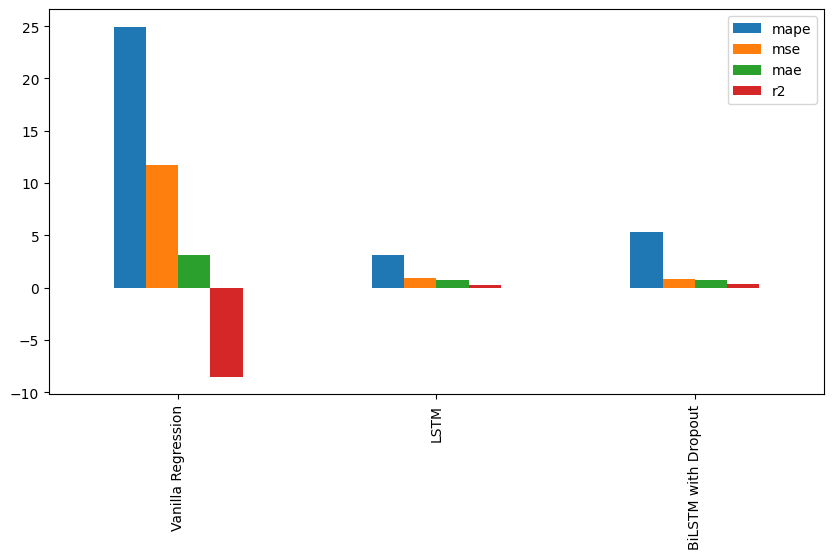

                          mape        mse       mae        r2
Vanilla Regression   24.954029  11.711807  3.085971 -8.496356
LSTM                  3.131733   0.965083  0.764279  0.217476
BiLSTM with Dropout   5.288566   0.828306  0.721616  0.328380
['GE' 'AAPL']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -24.78, MAE: 4.09, MAPE: 1902.78%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

R2: -0.88, MAE: 1.26, MAPE: 489.82%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

R2: -2.12, MAE: 1.70, MAPE: 665.83%


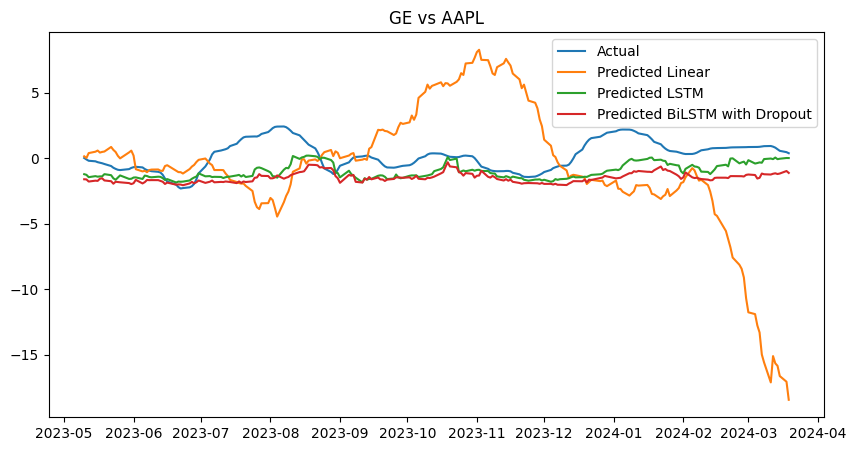

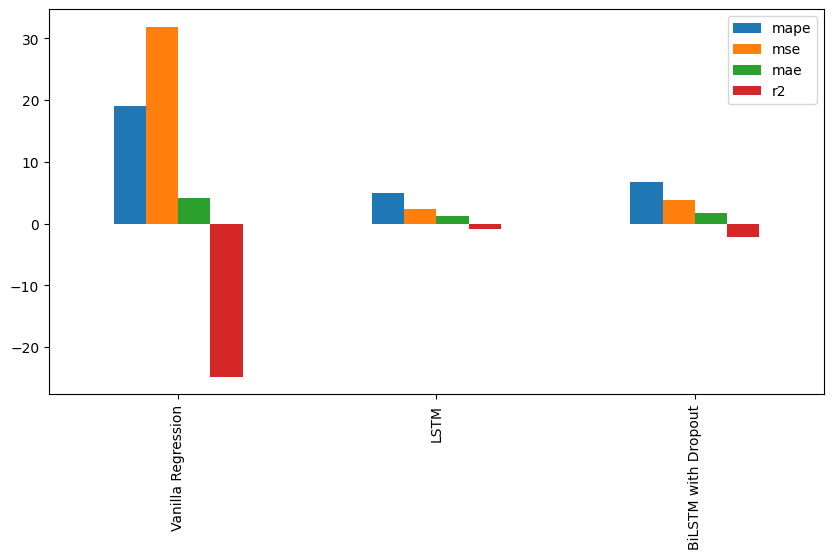

                          mape        mse       mae         r2
Vanilla Regression   19.027790  31.883809  4.093989 -24.778969
LSTM                  4.898158   2.326470  1.262408  -0.881018
BiLSTM with Dropout   6.658281   3.860352  1.700671  -2.121205
['GOOGL' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -17.16, MAE: 3.83, MAPE: 8276.10%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: 0.24, MAE: 0.76, MAPE: 674.51%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

R2: 0.05, MAE: 0.86, MAPE: 843.64%


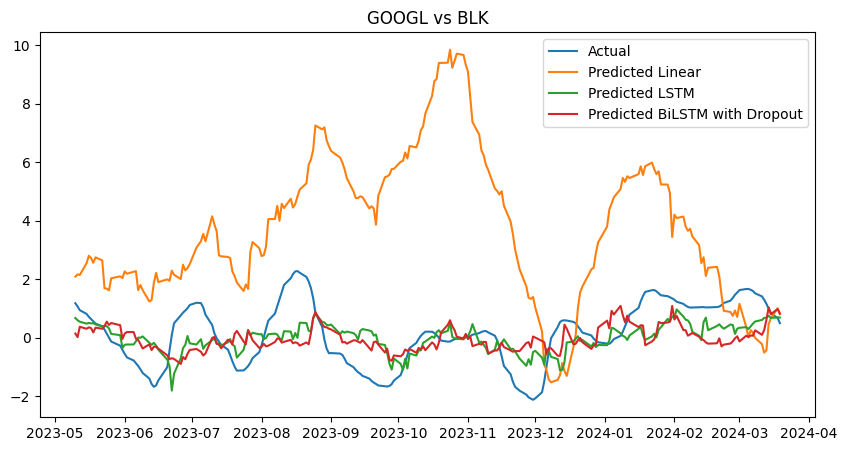

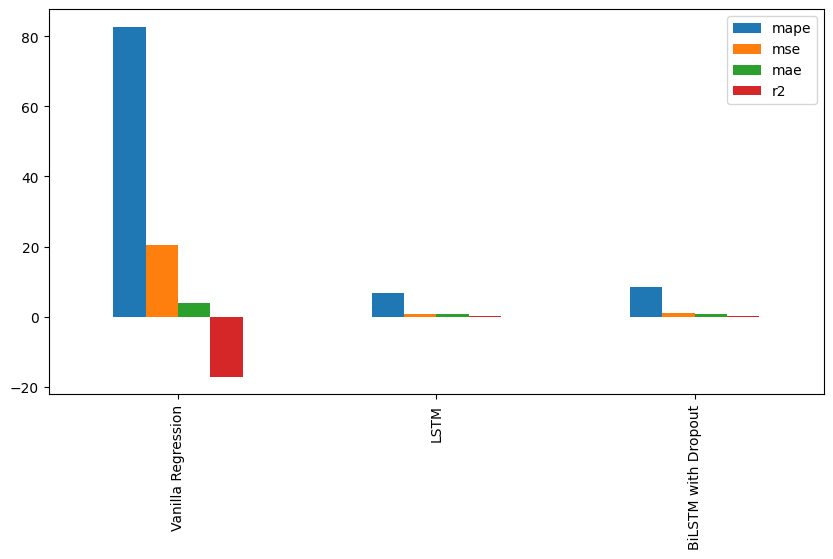

                          mape        mse       mae         r2
Vanilla Regression   82.761002  20.464315  3.832562 -17.155205
LSTM                  6.745062   0.861286  0.759474   0.235898
BiLSTM with Dropout   8.436363   1.072097  0.864334   0.048874
['JPM' 'FDX']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -2.97, MAE: 2.03, MAPE: 501.63%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: 0.26, MAE: 0.83, MAPE: 148.38%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

R2: 0.35, MAE: 0.83, MAPE: 153.61%


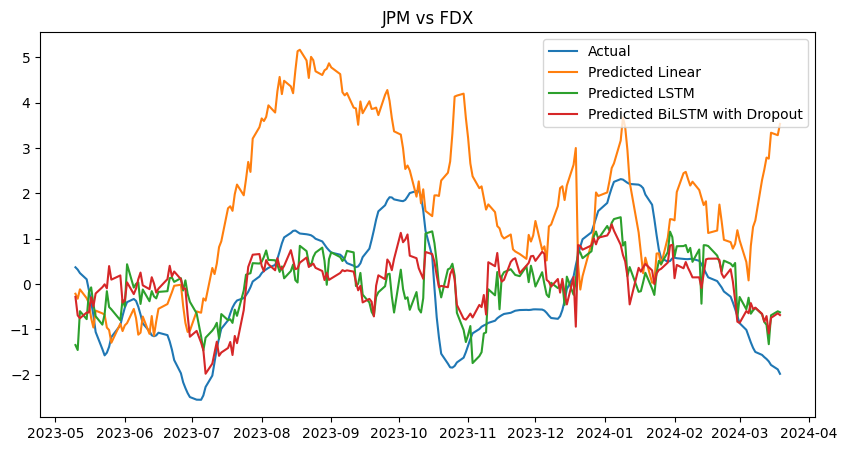

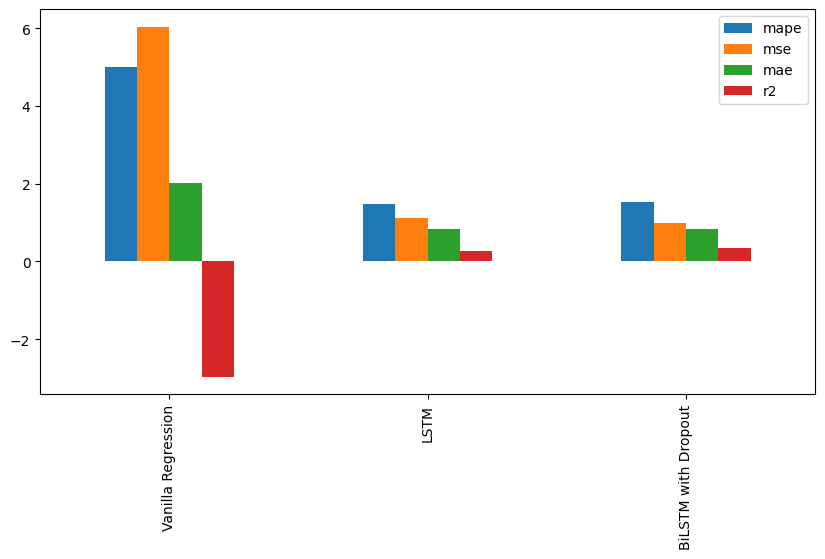

                         mape       mse       mae        r2
Vanilla Regression   5.016314  6.044121  2.028410 -2.965073
LSTM                 1.483793  1.128681  0.834165  0.259561
BiLSTM with Dropout  1.536076  0.990387  0.830365  0.350285
['JPM' 'HON']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -34.43, MAE: 6.47, MAPE: 5722.35%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

R2: 0.04, MAE: 1.09, MAPE: 604.22%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

R2: -0.12, MAE: 1.17, MAPE: 1325.62%


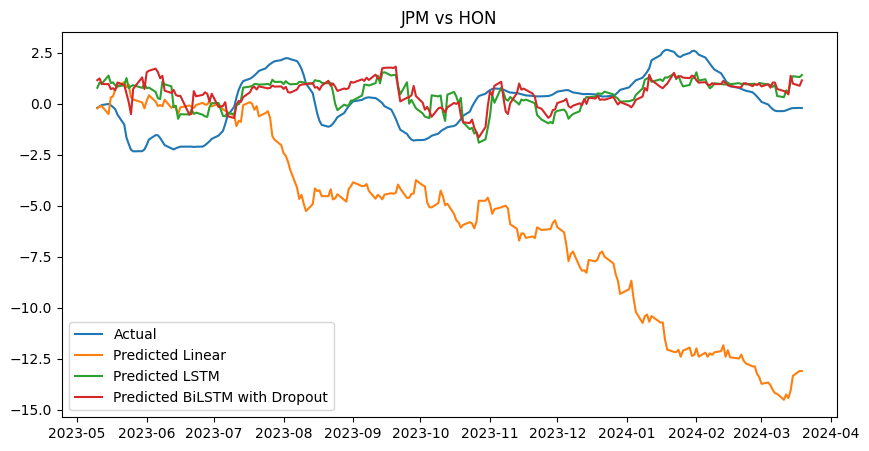

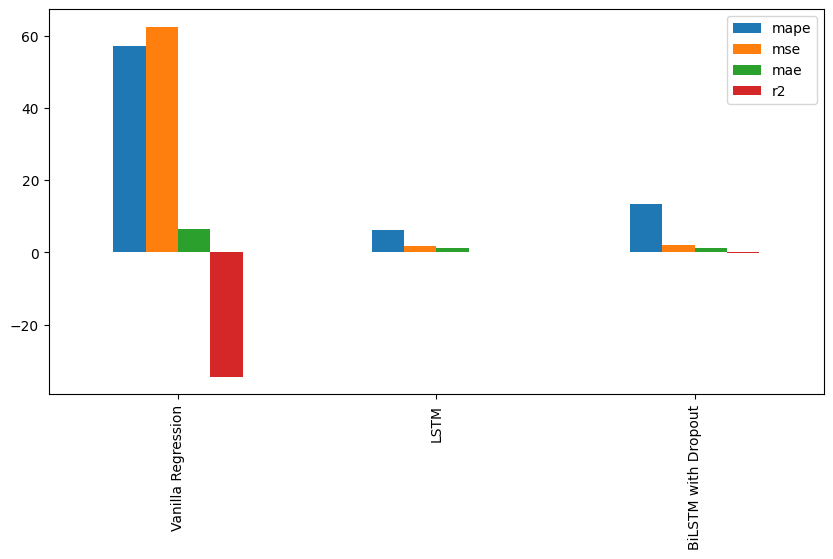

                          mape        mse       mae         r2
Vanilla Regression   57.223540  62.478579  6.467808 -34.428317
LSTM                  6.042182   1.700789  1.086406   0.035572
BiLSTM with Dropout  13.256197   1.979223  1.166773  -0.122313
['MS' 'HON']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     503  2023-05-10
Val       143  2023-08-24
Test       73  2023-12-04

R2: -1.07, MAE: 1.14, MAPE: 272.14%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

R2: -0.28, MAE: 0.87, MAPE: 212.28%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

R2: -0.21, MAE: 0.87, MAPE: 205.93%


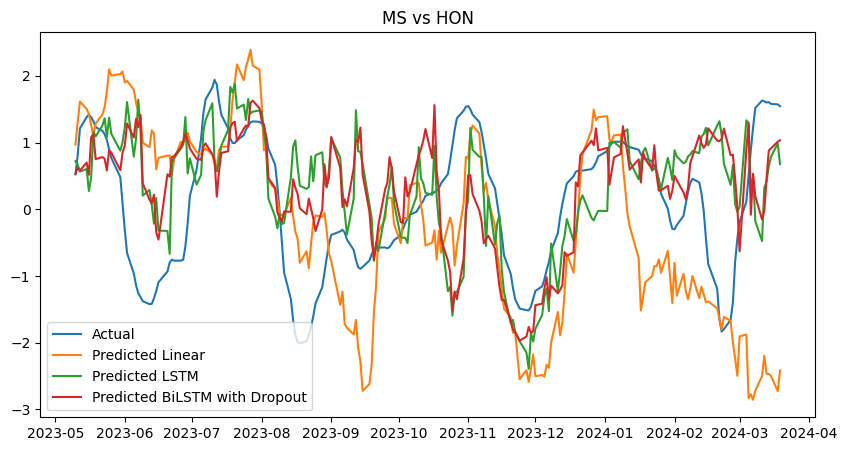

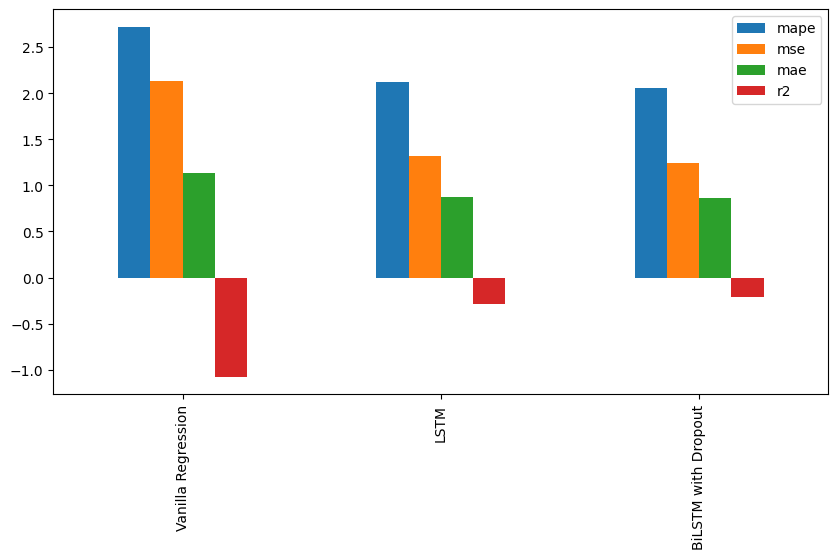

                         mape       mse       mae        r2
Vanilla Regression   2.721415  2.128399  1.135245 -1.074231
LSTM                 2.122827  1.316690  0.872719 -0.283180
BiLSTM with Dropout  2.059260  1.245532  0.865382 -0.213833


In [43]:
#import arima
from statsmodels.tsa.arima.model import ARIMA

# supress warnings
import warnings
warnings.filterwarnings("ignore")


# for each pairs, run the models
model_results = {}
for pair in pairs:
    print(pair)
    # Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
    pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
    if ADD_SENTIMENT_MA:
        pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns)

    # Join Technical Indicators
    pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")

    # Calculate Spread
    spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
    pair_df['spread'] = spread

    # Calculate Moving Z score Calculation (Trading Signal)
    ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
    ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
    std_high = pair_df.spread.rolling(window=MA_HIGH).std()

    moving_zscore = (ma_low - ma_high) / std_high
    pair_df['zscore_spread'] = moving_zscore

    train_data, val_data, test_data = create_dataset(
        pair_df, 
        look_back=LOOK_BACK, 
        target_col="zscore_spread", 
        drop_cols=DROP_COLS
    )

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

    # Combine val and test data since were not using Deep learning or hyper-param tuning 
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])

    model_reg = LinearRegression()
    model_reg.fit(X_train, y_train)

    y_pred_linear = model_reg.predict(X_test)

    model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred_linear)

    # # ARIMA model
    
    # arima_model = ARIMA(y_train, order=(5, 1, 0))
    # arima_model_fit = arima_model.fit()
    # y_pred_arima = arima_model_fit.forecast(len(y_test))[0]
    
    # model_results['ARIMA'] = calculate_metrics(y_test, y_pred_arima)
    
    
    
    # lstm
    padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
    padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)
    
    # Pad both training and testing feature sets
    X_train_padded = np.pad(X_train.values, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
    X_test_padded = np.pad(X_test.values, ((0, 0), (0, padding_test)), 'constant', constant_values=0)
    
    # Reshape both sets for LSTM
    X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
    X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))
    
    # Build the LSTM model
    model_lstm = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        LSTM(50),
        Dense(1)  # Output layer
        
    ])
    
    model_lstm.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model_lstm.fit(X_train_lstm, y_train, epochs=100, validation_split=0.1, verbose=0)
    
    # Predict
    y_pred_lstm = model_lstm.predict(X_test_lstm)
    
    # Evaluate
    model_results['LSTM'] = calculate_metrics(y_test, y_pred_lstm.flatten())
    
    # Build the Bidirectional LSTM model
    model_bilstm = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        Bidirectional(LSTM(50)),
        Dense(1)  # Output layer
    ])
    
    model_bilstm.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model_bilstm.fit(X_train_lstm, y_train, epochs=100, validation_split=0.1, verbose=0)
    
    # Predict
    y_pred_bilstm = model_bilstm.predict(X_test_lstm)
    
    # Evaluate
    model_results['BiLSTM with Dropout'] = calculate_metrics(y_test, y_pred_bilstm.flatten())
    
    # plot all together and show one loop in one plot

    plt.figure(figsize=(10, 5))
    plt.title(f'{pair[0]} vs {pair[1]}')
    plt.plot(y_test.index, y_test, label="Actual")
    plt.plot(y_test.index, y_pred_linear, label="Predicted Linear")
    plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
    plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
    plt.legend()
    plt.show()
    
    # elvaluate model results to dataframe and plot bar
    model_results_df = pd.DataFrame(model_results).T
    model_results_df.plot(kind='bar', figsize=(10, 5))
    plt.show()
    
    # print model results
    print(model_results_df)
    
    # save pickle
    
    model_results_df.to_pickle(f'../data/model_results/{pair[0]}_{pair[1]}_model_results.pkl')
    
    
    